# Problem statement

In the real estate industry, determining the appropriate rental price for a property is crucial for
property owners, tenants, and property management companies. Accurate rent predictions can
help landlords set competitive prices, tenants make informed rental decisions, and property
management companies optimize their portfolio management.
The goal of this project is to develop a data-driven model that predicts the rental price of
residential properties based on relevant features. By analyzing historical rental data and
property attributes, the model aims to provide accurate and reliable rent predictions.

# Needed packages

In [1]:
# for data reading and data manipulation
import numpy as np
import pandas as pd
import statistics as st
# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#other needs
import json
import ast
from geopy.geocoders import Nominatim
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import re

# for model creation and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Import the csv file

In [2]:
df = pd.read_excel("House_Rent_Train.xlsx")
#df.iloc[:,0].isnull().sum()
df.drop(df.tail(23).index , inplace=True) #Removing last 23 rows coz its full of null

In [3]:
pd.set_option('display.max_columns',None)

# Convert amenities into a new DF

In [4]:
num = 0
p_df = pd.DataFrame()
for i in range(0,20532):
    num = i
    d_j = json.loads(df.amenities[num])
    df_3 = pd.DataFrame(d_j,index=[i])
    p_df = pd.concat([p_df,df_3],ignore_index=True)
p_df

,LIFT,GYM,INTERNET,AC,CLUB,INTERCOM,POOL,CPA,FS,SERVANT,SECURITY,SC,GP,PARK,RWH,STP,HK,PB,VP
0,True,True,True,False,True,True,True,True,True,False,True,True,True,False,True,True,False,True,True
1,True,False,False,False,False,False,False,False,False,False,True,True,False,True,True,True,False,True,True
2,True,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,True,True
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20527,True,True,True,False,False,True,True,True,False,False,True,True,False,False,False,False,False,True,True
20528,False,False,True,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False
20529,True,True,True,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False
20530,True,False,True,False,False,False,False,True,True,False,True,True,False,True,False,False,True,True,True


In [5]:
#Need to drop repeated columns 
drop = ['LIFT','GYM','POOL']
p_df.drop(drop,axis=1,inplace=True)

In [6]:
p_df.astype(bool)

,INTERNET,AC,CLUB,INTERCOM,CPA,FS,SERVANT,SECURITY,SC,GP,PARK,RWH,STP,HK,PB,VP
0,True,False,True,True,True,True,False,True,True,True,False,True,True,False,True,True
1,False,False,False,False,False,False,False,True,True,False,True,True,True,False,True,True
2,False,False,False,False,True,False,False,False,True,False,True,False,False,False,True,True
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20527,True,False,False,True,True,False,False,True,True,False,False,False,False,False,True,True
20528,True,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False
20529,True,False,True,False,True,False,False,True,False,False,True,False,False,False,True,False
20530,True,False,False,False,True,True,False,True,True,False,True,False,False,True,True,True


# Merge both Dataframes

In [7]:
Df = pd.DataFrame()
Df = pd.concat([Df,df,p_df],axis=1)

In [8]:
#Filling all absent values as False

Df['CLUB'].fillna(False,inplace=True)
Df['CPA'].fillna(False,inplace=True)
Df['GP'].fillna(False,inplace=True)
Df['RWH'].fillna(False,inplace=True)
Df['STP'].fillna(False,inplace=True)
Df['VP'].fillna(False,inplace=True)
Df

,id,type,locality,activation_date,latitude,longitude,lease_type,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,amenities,water_supply,building_type,balconies,rent,INTERNET,AC,CLUB,INTERCOM,CPA,FS,SERVANT,SECURITY,SC,GP,PARK,RWH,STP,HK,PB,VP
0,ff8081815733a243015733b2876600a6,BHK2,NaN,21-04-2018 14:44,12.934471,77.634471,FAMILY,1,1,1,0,SEMI_FURNISHED,BOTH,1250,25.0,2.0,E,2.0,6.0,12.0,"{""LIFT"":true,""GYM"":true,""INTERNET"":true,""AC"":f...",CORP_BORE,AP,2.0,40000.0,True,False,True,True,True,True,False,True,True,True,False,True,True,False,True,True
1,ff8081815ee25e15015ee50004da2acd,BHK2,Bellandur,2017-09-10 12:48:00,12.929557,77.672280,ANYONE,0,1,0,1,SEMI_FURNISHED,BOTH,1400,4.0,2.0,NE,2.0,3.0,4.0,"{""LIFT"":true,""GYM"":false,""INTERNET"":false,""AC""...",CORPORATION,AP,2.0,22000.0,False,False,False,False,False,False,False,True,True,False,True,True,True,False,True,True
2,ff80818163f29c9e0163f46770b873e7,BHK3,Thiruvanmiyur,2018-12-06 22:02:00,12.982870,80.262012,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1350,6.0,3.0,E,3.0,1.0,5.0,"{""LIFT"":true,""GYM"":false,""INTERNET"":false,""AC""...",CORP_BORE,AP,3.0,28000.0,False,False,False,False,True,False,False,False,True,False,True,False,False,False,True,True
3,ff80818164b68a700164b74b1b247a1d,BHK1,Attiguppe,20-07-2018 16:22,12.955991,77.531634,FAMILY,0,0,0,1,SEMI_FURNISHED,TWO_WHEELER,600,3.0,1.0,E,1.0,1.0,2.0,"{""LIFT"":false,""GYM"":false,""INTERNET"":false,""AC...",CORPORATION,IH,0.0,8000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,ff80818163b1faf00163b4b9b8a163b1,BHK3,Kodihalli,31-05-2018 17:41,12.963903,77.649446,FAMILY,0,0,0,1,SEMI_FURNISHED,BOTH,1500,15.0,3.0,E,4.0,0.0,0.0,"{""LIFT"":false,""GYM"":false,""INTERNET"":false,""AC...",CORPORATION,IH,1.0,45000.0,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20527,ff8081815b48bfdd015b4d0e6e720dde,NaN,"Gattigere,RR Nagar",13-12-2017 18:08,12.925380,77.524397,ANYONE,1,1,1,1,SEMI_FURNISHED,BOTH,1650,1.0,3.0,E,3.0,4.0,4.0,"{""LIFT"":true,""GYM"":true,""INTERNET"":true,""AC"":f...",BOREWELL,AP,2.0,25000.0,True,False,False,True,True,False,False,True,True,False,False,False,False,False,True,True
20528,ff8081815e73c2e2015e74ac10e91975,BHK2,Koramangala 4th Block,19-10-2017 20:31,12.931072,77.632361,ANYONE,0,0,0,1,SEMI_FURNISHED,BOTH,1000,10.0,2.0,N,2.0,1.0,2.0,"{""LIFT"":false,""GYM"":false,""INTERNET"":true,""AC""...",CORPORATION,IH,2.0,30000.0,True,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False
20529,ff8081816073f28c016077bb8db47e4f,BHK2,Kumaraswamy Layout,21-12-2017 21:18,12.901800,77.566597,FAMILY,1,1,0,1,SEMI_FURNISHED,BOTH,1000,0.0,2.0,W,2.0,5.0,5.0,"{""LIFT"":true,""GYM"":true,""INTERNET"":true,""AC"":f...",BOREWELL,AP,2.0,16000.0,True,False,True,False,True,False,False,True,False,False,True,False,False,False,True,False
20530,ff8081814c6f8c9b014c6febae49016f,BHK2,Indiranagar,28-06-2018 21:58,12.965502,77.647694,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1000,5.0,2.0,E,2.0,2.0,4.0,"{""LIFT"":true,""GYM"":false,""INTERNET"":true,""AC"":...",CORP_BORE,AP,3.0,30000.0,True,False,False,False,True,True,False,True,True,False,True,False,False,True,True,True


In [9]:
null_df = Df[Df['locality'].isnull()]
l = pd.concat([null_df['latitude'],null_df['longitude'],null_df['locality'],null_df['id']],ignore_index=False,axis=1)
pp = pd.DataFrame(l)
pp

,latitude,longitude,locality,id
0,12.934471,77.634471,NaN,ff8081815733a243015733b2876600a6
68,12.916572,77.653858,NaN,ff8081815d78fafd015d791fc8900579
126,12.988281,77.698081,NaN,ff808181639be7ee0163a112372249ca
530,12.904404,77.570353,NaN,ff8081815df53cd2015df912740e49cb
604,12.926315,77.596777,NaN,ff80818164e57f1d0164e6c10f6f3cdf
...,...,...,...,...
20393,12.968302,77.527154,NaN,ff8081815f38b3ba015f3982c869626c
20394,12.969651,77.658173,NaN,ff80818162862034016286c9ca366a7f
20433,12.920966,77.607557,NaN,ff8081815c95dda7015c964401752063
20434,12.920497,77.560153,NaN,ff808181594a89df01594f7ef80e0e3b


In [10]:
#Finding NAN locality using latitude and longitude

In [11]:
def find_location(pp):
    geolocator = Nominatim(user_agent="location_finder")
    location = geolocator.reverse((pp['latitude'], pp['longitude']), exactly_one=True)
    
    if location:
        return location.address
    
pp['locality'] = pp.apply(find_location, axis=1)

In [12]:
#Drop latitude and longitude from pp 
pp.drop(columns='latitude',inplace=True,axis=1)
pp.drop(columns='longitude',inplace=True,axis=1)

In [13]:
# Define a function to convert to a single word if "area name" is present
def convert_to_single_word(cell_text, target_word):
    words = cell_text.split(',')
    for word in words:
        if target_word in word:
            return target_word
    return cell_text

# Apply the function using lambda function
word = ['Bommanahalli','Mahadevapura','MSO Colony','Siddapura','Bismillah Nagar','Sriramamandir Ward','Malleshpalya','Basavanagudi Ward','Bhuvaneshwari Nagar','Attiguppe Ward','BTM Layout Ward','Mahadeshwara Nagara','Hoysala Nagara','Kaggadasapura','Kottigepalya','City Market','Madivala','Rajarajeshwari Nagar','Katriguppe','Jakkasandra','J P Nagar','Pattabhiram Nagar','Mailasandra','Agaram','Kumaraswamy Layout','Kurubara Halli','Domlur','Gayatri Nagara','Saneguruvanahalli','Austin Town BDA Layout','Dasarahalli','Halasooru','GM Palya','GKW Layout','Corporation Colony','Cottonpete','Koramangala','Jeevanbhima Nagar','Jogupalya']
for i in word:
    target_word = i
    pp['locality'] = pp['locality'].apply(lambda x: convert_to_single_word(x, target_word))
pp

,locality,id
0,Agaram,ff8081815733a243015733b2876600a6
68,Bommanahalli,ff8081815d78fafd015d791fc8900579
126,Mahadevapura,ff808181639be7ee0163a112372249ca
530,Bommanahalli,ff8081815df53cd2015df912740e49cb
604,Pattabhiram Nagar,ff80818164e57f1d0164e6c10f6f3cdf
...,...,...
20393,GKW Layout,ff8081815f38b3ba015f3982c869626c
20394,Mahadevapura,ff80818162862034016286c9ca366a7f
20433,Bismillah Nagar,ff8081815c95dda7015c964401752063
20434,Kumaraswamy Layout,ff808181594a89df01594f7ef80e0e3b


In [14]:
#Create DF_ and insert pp and DF into it
Df_ = Df.combine_first(pp)
column_p = ['id', 'type', 'locality', 'activation_date', 'latitude', 'longitude','lease_type', 'gym', 'lift', 'swimming_pool', 'negotiable','furnishing', 'parking', 'property_size', 'property_age', 'bathroom','facing', 'cup_board', 'floor', 'total_floor', 'amenities','water_supply', 'building_type', 'balconies', 'rent', 'INTERNET', 'AC','CLUB', 'INTERCOM', 'CPA', 'FS', 'SECURITY', 'SC', 'GP', 'PARK', 'RWH','STP', 'HK', 'PB', 'VP']

In [15]:
D_F = Df_[column_p]
D_F

,id,type,locality,activation_date,latitude,longitude,lease_type,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,amenities,water_supply,building_type,balconies,rent,INTERNET,AC,CLUB,INTERCOM,CPA,FS,SECURITY,SC,GP,PARK,RWH,STP,HK,PB,VP
0,ff8081815733a243015733b2876600a6,BHK2,Agaram,21-04-2018 14:44,12.934471,77.634471,FAMILY,1,1,1,0,SEMI_FURNISHED,BOTH,1250,25.0,2.0,E,2.0,6.0,12.0,"{""LIFT"":true,""GYM"":true,""INTERNET"":true,""AC"":f...",CORP_BORE,AP,2.0,40000.0,True,False,True,True,True,True,True,True,True,False,True,True,False,True,True
1,ff8081815ee25e15015ee50004da2acd,BHK2,Bellandur,2017-09-10 12:48:00,12.929557,77.672280,ANYONE,0,1,0,1,SEMI_FURNISHED,BOTH,1400,4.0,2.0,NE,2.0,3.0,4.0,"{""LIFT"":true,""GYM"":false,""INTERNET"":false,""AC""...",CORPORATION,AP,2.0,22000.0,False,False,False,False,False,False,True,True,False,True,True,True,False,True,True
2,ff80818163f29c9e0163f46770b873e7,BHK3,Thiruvanmiyur,2018-12-06 22:02:00,12.982870,80.262012,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1350,6.0,3.0,E,3.0,1.0,5.0,"{""LIFT"":true,""GYM"":false,""INTERNET"":false,""AC""...",CORP_BORE,AP,3.0,28000.0,False,False,False,False,True,False,False,True,False,True,False,False,False,True,True
3,ff80818164b68a700164b74b1b247a1d,BHK1,Attiguppe,20-07-2018 16:22,12.955991,77.531634,FAMILY,0,0,0,1,SEMI_FURNISHED,TWO_WHEELER,600,3.0,1.0,E,1.0,1.0,2.0,"{""LIFT"":false,""GYM"":false,""INTERNET"":false,""AC...",CORPORATION,IH,0.0,8000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,ff80818163b1faf00163b4b9b8a163b1,BHK3,Kodihalli,31-05-2018 17:41,12.963903,77.649446,FAMILY,0,0,0,1,SEMI_FURNISHED,BOTH,1500,15.0,3.0,E,4.0,0.0,0.0,"{""LIFT"":false,""GYM"":false,""INTERNET"":false,""AC...",CORPORATION,IH,1.0,45000.0,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20527,ff8081815b48bfdd015b4d0e6e720dde,NaN,"Gattigere,RR Nagar",13-12-2017 18:08,12.925380,77.524397,ANYONE,1,1,1,1,SEMI_FURNISHED,BOTH,1650,1.0,3.0,E,3.0,4.0,4.0,"{""LIFT"":true,""GYM"":true,""INTERNET"":true,""AC"":f...",BOREWELL,AP,2.0,25000.0,True,False,False,True,True,False,True,True,False,False,False,False,False,True,True
20528,ff8081815e73c2e2015e74ac10e91975,BHK2,Koramangala 4th Block,19-10-2017 20:31,12.931072,77.632361,ANYONE,0,0,0,1,SEMI_FURNISHED,BOTH,1000,10.0,2.0,N,2.0,1.0,2.0,"{""LIFT"":false,""GYM"":false,""INTERNET"":true,""AC""...",CORPORATION,IH,2.0,30000.0,True,False,False,False,False,False,False,True,False,True,True,False,False,False,False
20529,ff8081816073f28c016077bb8db47e4f,BHK2,Kumaraswamy Layout,21-12-2017 21:18,12.901800,77.566597,FAMILY,1,1,0,1,SEMI_FURNISHED,BOTH,1000,0.0,2.0,W,2.0,5.0,5.0,"{""LIFT"":true,""GYM"":true,""INTERNET"":true,""AC"":f...",BOREWELL,AP,2.0,16000.0,True,False,True,False,True,False,True,False,False,True,False,False,False,True,False
20530,ff8081814c6f8c9b014c6febae49016f,BHK2,Indiranagar,28-06-2018 21:58,12.965502,77.647694,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1000,5.0,2.0,E,2.0,2.0,4.0,"{""LIFT"":true,""GYM"":false,""INTERNET"":true,""AC"":...",CORP_BORE,AP,3.0,30000.0,True,False,False,False,True,True,True,True,False,True,False,False,True,True,True


In [16]:
#Filled NAN types based on their balconies and size and type
type_df = D_F[D_F['type'].isna()]
types = pd.concat([type_df['type'],type_df['property_size'],type_df['balconies'],type_df['building_type']],axis=1,ignore_index=False)
types['type'].fillna('BHK2',inplace=True)
#print(types) if we need remove command and see it

In [17]:
DF_ = D_F.combine_first(types)
DF = DF_[column_p]

In [18]:
#make all types as smaller case 
DF['type']=DF['type'].str.lower()
DF['type'].replace({'1bhk1':'bhk1','bhk4plus':'bhk4'},inplace=True)

In [19]:
#Remove amenties 
DF.drop('amenities',axis=1,inplace=True)

In [20]:
#---------------To remove Duplicated Id's------------------#
DF.drop(DF.tail(32).index,inplace=True)
#---------------Duplicated Id's removed------------------#

In [21]:
#make DF['locality'] and DF['id'] as a DF
area_info = pd.concat([DF['locality'],DF['id']],ignore_index=False,axis=1)
area_df = pd.DataFrame(area_info)

# Convert all the localities as a single word

In [22]:
# Define a function to convert to a single word if "area name" is present
def convert_to_single_word(cell_text, target_word):
    words = cell_text.split(',')
    for word in words:
        if target_word in word:
            return target_word
    return cell_text

# Apply the function using lambda function
word = ['Whitefield','Attiguppe','Bommanahalli','Kodihalli','Bellandur','Vishweshwarapura','JP Nagar','HSR Layout','Doctor Ambedkar Nagar Road','Seetharampalya','Mahadevapura','Kodihalli','Hoodi','Pulikeshi Nagar','Halanayakanahalli','Yelachenahallli','MSO Colony','Krishnarajapura','Siddapura','Bismillah Nagar','Sriramamandir Ward','Malleshpalya','Basavanagudi Ward','Bhuvaneshwari Nagar','Attiguppe Ward','BTM Layout Ward','Mahadeshwara Nagara','Hoysala Nagara','Kaggadasapura','Kottigepalya','City Market','Madivala','Rajarajeshwari Nagar','Katriguppe','Jakkasandra','J P Nagar','Pattabhiram Nagar','Mailasandra','Agaram','Kumaraswamy Layout','Kurubara Halli','Domlur','Gayatri Nagara','Saneguruvanahalli','Austin Town BDA Layout','Dasarahalli','Halasooru','GM Palya','GKW Layout','Corporation Colony','Cottonpete','Koramangala','Jeevanbhima Nagar','Jogupalya']
for i in word:
    target_word = i
    area_df['locality'] = area_df['locality'].apply(lambda x: convert_to_single_word(x, target_word))
#print(area_df)

In [23]:
# Define a function to convert to a single word if "area name" is present

#----------------SECOND SET----------------------#
def convert_to_single_word(cell_text, target_word):
    words = cell_text.split(',')
    for word in words:
        if target_word in word:
            return target_word
    return cell_text

# Apply the function using lambda function
words=['Jayanagar','Srinagar','Srirampura','Kasavanahalli','Bilekahalli','Jeevan Bima Nagar','Sheshadripuram','Uttarahalli Hobli','Kalasipalya','Ejipura','Vimanapura','Suddagunte Palya','Govindaraja Nagar Ward','Tavarekere','Vivek Nagar','Nagarbhavi','Indiranagar','Bennigana Halli','Rajaji Nagar','Rajarajeshwarinagar','Vijayanagar','Nayanda Halli','Vignan Nagar','BTM Layout','Basaveshwar Nagar','New Tippasandra','Hosakerehalli','Doddakannelli','Marathahalli','Harlur','Chandra Layout','Murgesh Pallya','BTM Layout 2nd Stage','Shivaji Nagar','AECS Layout','Chinnapanna Halli','Basavanagara','Adugodi','Vijaya Nagar','Maruti Nagar','RR Nagar','Raja Rajeshwari Nagar','C V Raman Nagar','Brookefield','Munnekollal','Doddanekkundi','Marathahalli','Pantarapalya','Brindavan Layout','Banashankari','Nagavarapalya','Kadugodi','Varthur','Basavanagudi','Padmanabhanagar']

for i in words:
    target_word = i
    area_df['locality'] = area_df['locality'].apply(lambda x: convert_to_single_word(x, target_word))
#print(area_df)

In [24]:
# Define a function to convert to a single word if "area name" is present

#----------------THIRD SET----------------------#
def convert_to_single_word(cell_text, target_word):
    words = cell_text.split(',')
    for word in words:
        if target_word in word:
            return target_word
    return cell_text

# Apply the function using lambda function
Words = ['Ulsoor','Chickpet','Hermit Colony','Nagarathpete','Koralur','Kodipur','Yellagondanpalya','Balagere','Chamrajpet','Somasundarapalaya','koralur','Amblipura','Ferns City','Someshwara Nagar','Vibhutipura','Wilson Garden','Deepanjali Nagar','Byagadadenahalli Bus Stop','Annasandrapalya Extension','Subramanyanagar','Embassy Tech Village','Carmelaram','Channasandra','Doopanahalli','HAL','Ayyappa Nagar','Kaveri Pura','HSR 7th Sector','NGR Layout','Hosapalaya','Pattandhur Agrahar Village','Jyothi Puram','Gunjur Village','Binnipete','Bhoganhalli','Kanakpura Main Road','Sripuram','Mangammanapalya','Yattakodi','Mysore Road Satellite Bus Station','Kaikondrahalli','Chansandra','Thurahalli','Kodbisanhalli','Panathur','Somasundarapalya','Prestige Shanthinikethan','MARATHALLI','Chandana','Kadubeesanahalli','BTM','Yemalur','Chikkakannalli','Chikkalasandra','Murugeshpalya','shivajinagar','Maruthi Sevanagar','ITI Layout','Doddanekundi','Jeevanhalli']
for i in Words:
    target_word = i
    area_df['locality'] = area_df['locality'].apply(lambda x: convert_to_single_word(x, target_word))
#print(area_df)

In [25]:
# Define a function to convert to a single word if "area name" is present

#----------------FOURTH SET----------------------#
def convert_to_single_word(cell_text, target_word):
    words = cell_text.split(',')
    for word in words:
        if target_word in word:
            return target_word
    return cell_text

# Apply the function using lambda function
Word=['Narayanapura','Cashier Layout','NR Colony','Kempegowda Nagar','Sudhama Nagar','Mudalapalya','Basaweshwara Nagar','Pattegarhpalya','CV Raman Nagar','Kurubarahalli','Purva Riviera','Rasanna Colony','Uday Nagar','Viveka Nagar','Jayamahal','Medavakkam','Giri Nagar','Guttahalli','Palace Guttahalli','Subramanyapura','VijayaSri Elixir','Malleshwaram','Vannarpet','Junnasandra','Neelasandra','Muneshwara Nagar','Devaiah Park','Maithri Layout','Byrasandra','Anepalya','Gunjur','Naganathapura','L B Sastry Nagar Lake','Richmond Town','Kumara Park East','Thubarahalli','Halasuru','Kamala Nagar','K.R Puram','Samethanahalli','Sarjapur','Tin factory','Mahalakshmipuram','Jagadish Nagar','KHB Colony','JayaNagar','Udaya Nagar','vinayakanagar','Bhoomi Reddy Colony','Chennammanakere Achukattu','behind udupi garden','Bhanu Residency','Veracious Rosedale']
for i in Word:
    target_word = i
    area_df['locality'] = area_df['locality'].apply(lambda x: convert_to_single_word(x, target_word))

area_df.loc[11][0]='Pattanduru Agrahara'
area_df.loc[19][0]='Agaram'   

In [26]:
area_df['locality'] = area_df.locality.replace({'J P Nagar':'JP Nagar','J. P. Nagar':'JP Nagar','Doddanakundi':'Doddanekkundi','J P Nagar':'JP Nagar','J.P. Nagar':'JP Nagar','Jeevan Bima Nagar':'Jeevanbheemanagar','RR Naga':'RR Nagar','Padmanbhanagar':'Padmanabhanagar','White filed':'Whitefield','Raja Rajeshwarinagar':'Raja Rajeshwari Nagar','Cox Town, Bengaluru, Karnataka, India':'Cox Town','J.P.Nagar':'JP Nagar','J. P. Nagar, Bengaluru, Karnataka, India':'JP Nagar','HSR layout sector 6':'HSR Layout','rajarajeshwarinagar':'Raja Rajeshwari Nagar','Basaveshwara Nagar':'Basaveshwar Nagar','Basaweshwar nagar':'Basaveshwar Nagar','Bhyraveshwara Nagar':'Basaveshwar Nagar','Bommenahalli':'Bommanahalli','C.V. Raman Nagar':'C V Raman Nagar','Krishnapura':'Krishnarajapura','RajaRajeshwari Nagar':'Raja Rajeshwari Nagar','Billekahalli':'Bilekahalli','RR nagar':'RR Nagar','Basaveshwaranagar':'Basaveshwar Nagar','J P NAGAR':'JP Nagar','Chinnappanahalli':'Chinnapanna Halli','Thippasandra':'New Tippasandra','basaveshwara Nagar':'Basaveshwar Nagar','Basavana nagar, hoodi':'Hoodi','Raja rajeshwari nagar':'Raja Rajeshwari Nagar','J.P Nagar 4th Phase':'JP Nagar','Vijaynagar':'Vijayanagar','Rajarajeshwari nagar':'Raja Rajeshwari Nagar','Basaveshwar Nagar':'Basaveshwar Nagar','Basaveshwara Nagar 3rd stage':'Basaveshwar Nagar','Iblur Village,Agram':'Agaram','Cox town':'Cox Town','JP nagar 2nd phase':'JP Nagar','BTm lyout':'BTM','Vijay Nagar':'Vijaya Nagar','Jeevan Bhimanagar':'Jeevanbheemanagar','Jeevan Bhima Nagar':'Jeevanbheemanagar','JeevanBhima Nagar':'Jeevanbheemanagar','Rajarajeshwari Nagar':'Raja Rajeshwari Nagar','Byraveshwara Nagar':'Basaveshwar Nagar','Basaveswarnagar':'Basaveshwar Nagar','kormangala':'Koramangala','Doddanekundi':'Doddanekkundi','DODDANAKUNDI':'Doddanekkundi','R R Nagar':'RR Nagar','Mahdevpura':'Mahadevapura','HSR':'HSR Layout','HSR layout 3rd sector':'HSR Layout','banashankari':'Banashankari','Banashankar':'Banashankari','hsr layout':'HSR Layout','J.P. Nagar':'JP Nagar','Agram':'Agaram','wilson garden':'Wilson Garden','Doctor Ambedkar Nagar Road':'Doctor Ambedkar Nagar'})


area_df['locality'] = area_df.locality.replace({'Chinnappana Halli':'Chinnapanna Halli','Tippasandra':'New Tippasandra','Vijayanagar':'Vijaya Nagar','Rajarajeshwari Nagar':'Raja Rajeshwari Nagar','CV Raman Nagar':'C V Raman Nagar','Koramanagala':'Koramangala','Basaweshwara Nagar':'Basaveshwar Nagar','Rajarajeshwarinagar':'Raja Rajeshwari Nagar','Rajajinagar':'Rajaji Nagar','New Thippasandra':'New Tippasandra','New Thipasandra':'New Tippasandra','HSR layout':'HSR Layout','vijayanagar':'Vijaya Nagar','Basavanna Nagar':'Basaveshwar Nagar','HSR 6th Sector':'HSR Layout','Rajaji Nagar ':'Rajaji Nagar','Chinnapanahalli':'Chinnapanna Halli','Btm Layout 2nd Stage':'BTM','sarjapur main road':'Sarjapur','Padmanabha Nagar':'Padmanabhanagar','Basaveshvara Nagar':'Basaveshwar Nagar','Basavanagar':'Basaveshwar Nagar','Vijay nagar':'Vijaya Nagar','Rajarajeswari Nagar':'Raja Rajeshwari Nagar','White Field':'Whitefield','Indira Nagar 1st Stage':'Indiranagar','H A L 2nd Stage':'HAL','Doddakannalli':'Doddakannelli','HSR layout Sector 2':'HSR Layout','New Thippsandra':'New Tippasandra','R.R Nagar':'RR Nagar','Padmanabha nagar':'Padmanabhanagar','S Cadambi Vidya Kendra English Secondary School, 10th B Main Road, Basaveshwaranagar, Basaveshwara Nagar Ward, West Zone, Bengaluru, Bangalore North, Bengaluru Urban District, Karnataka, 560079, India':'Basaveshwar Nagar','Basava Nagar':'Basaveshwar Nagar','Bilekehalli':'Bilekahalli','Btm 2nd Stage':'BTM','Egipura':'Ejipura','Kodigehalli':'Kodihalli','Hudi':'Hoodi','Bomanahalli':'Bommanahalli','Kormangala':'Koramangala','null,null':'BTM','HSR 7th Sector':'HSR Layout','Doddakanelli':'Doddakannelli','HSR layout 5th Sector':'HSR Layout','whitefield':'Whitefield','Rajajinagar 6th Block':'Rajaji Nagar','Byraveshwaranagar':'Basaveshwar Nagar','Basavangudi':'Basavanagudi','#8 1st  main. 4th cross Bhuvaneshwari nagar. c.v Ramannagar Bangalore 560093. opp konda residency':'C V Raman Nagar'})


In [27]:
column_n = ['id', 'type', 'locality', 'activation_date', 'latitude', 'longitude','lease_type', 'gym', 'lift', 'swimming_pool', 'negotiable','furnishing', 'parking', 'property_size', 'property_age', 'bathroom','facing', 'cup_board', 'floor', 'total_floor','water_supply', 'building_type', 'balconies', 'rent', 'INTERNET', 'AC','CLUB', 'INTERCOM', 'CPA', 'FS', 'SECURITY', 'SC', 'GP', 'PARK', 'RWH','STP', 'HK', 'PB', 'VP']
main_df = DF.combine_first(area_df)
main_DF = main_df[column_n]
main_DF

,id,type,locality,activation_date,latitude,longitude,lease_type,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,water_supply,building_type,balconies,rent,INTERNET,AC,CLUB,INTERCOM,CPA,FS,SECURITY,SC,GP,PARK,RWH,STP,HK,PB,VP
0,ff8081815733a243015733b2876600a6,bhk2,Agaram,21-04-2018 14:44,12.934471,77.634471,FAMILY,1,1,1,0,SEMI_FURNISHED,BOTH,1250,25.0,2.0,E,2.0,6.0,12.0,CORP_BORE,AP,2.0,40000.0,True,False,True,True,True,True,True,True,True,False,True,True,False,True,True
1,ff8081815ee25e15015ee50004da2acd,bhk2,Bellandur,2017-09-10 12:48:00,12.929557,77.672280,ANYONE,0,1,0,1,SEMI_FURNISHED,BOTH,1400,4.0,2.0,NE,2.0,3.0,4.0,CORPORATION,AP,2.0,22000.0,False,False,False,False,False,False,True,True,False,True,True,True,False,True,True
2,ff80818163f29c9e0163f46770b873e7,bhk3,Thiruvanmiyur,2018-12-06 22:02:00,12.982870,80.262012,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1350,6.0,3.0,E,3.0,1.0,5.0,CORP_BORE,AP,3.0,28000.0,False,False,False,False,True,False,False,True,False,True,False,False,False,True,True
3,ff80818164b68a700164b74b1b247a1d,bhk1,Attiguppe,20-07-2018 16:22,12.955991,77.531634,FAMILY,0,0,0,1,SEMI_FURNISHED,TWO_WHEELER,600,3.0,1.0,E,1.0,1.0,2.0,CORPORATION,IH,0.0,8000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,ff80818163b1faf00163b4b9b8a163b1,bhk3,Kodihalli,31-05-2018 17:41,12.963903,77.649446,FAMILY,0,0,0,1,SEMI_FURNISHED,BOTH,1500,15.0,3.0,E,4.0,0.0,0.0,CORPORATION,IH,1.0,45000.0,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20495,ff8081815b48bfdd015b4d0e6e720dde,bhk2,"Gattigere,RR Nagar",13-12-2017 18:08,12.925380,77.524397,ANYONE,1,1,1,1,SEMI_FURNISHED,BOTH,1650,1.0,3.0,E,3.0,4.0,4.0,BOREWELL,AP,2.0,25000.0,True,False,False,True,True,False,True,True,False,False,False,False,False,True,True
20496,ff8081815e73c2e2015e74ac10e91975,bhk2,Koramangala 4th Block,19-10-2017 20:31,12.931072,77.632361,ANYONE,0,0,0,1,SEMI_FURNISHED,BOTH,1000,10.0,2.0,N,2.0,1.0,2.0,CORPORATION,IH,2.0,30000.0,True,False,False,False,False,False,False,True,False,True,True,False,False,False,False
20497,ff8081816073f28c016077bb8db47e4f,bhk2,Kumaraswamy Layout,21-12-2017 21:18,12.901800,77.566597,FAMILY,1,1,0,1,SEMI_FURNISHED,BOTH,1000,0.0,2.0,W,2.0,5.0,5.0,BOREWELL,AP,2.0,16000.0,True,False,True,False,True,False,True,False,False,True,False,False,False,True,False
20498,ff8081814c6f8c9b014c6febae49016f,bhk2,Indiranagar,28-06-2018 21:58,12.965502,77.647694,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1000,5.0,2.0,E,2.0,2.0,4.0,CORP_BORE,AP,3.0,30000.0,True,False,False,False,True,True,True,True,False,True,False,False,True,True,True


In [28]:
# Define a function to convert to a single word if "area name" is present

#----------------First SET----------------------#
def convert_to_single_word(cell_text, target_word):
    words = cell_text.split(',')
    for word in words:
        if target_word in word:
            return target_word
    return cell_text

# Apply the function using lambda function
city = ['Krishnarajapura','Murgesh Pallya','CV Raman Nagar','ambalipura','NR Colony','Vishweshwarapura','Doctor Ambedkar Nagar Road','Mudalapalya','Basaweshwara Nagar','Pattegarhpalya','Nagarabhavi 2nd Stage','Viveka Nagar','Anepalya','Vannarpet Layout','Basaweshwara Nagar','Purva Riviera','Rasanna Colony','Uday Nagar','Jayamahal','Ranganathapuram','Medavakkam','Giri Nagar','Ittamadu Main','Guttahalli','Palace Guttahalli','Subramanyapura','VijayaSri Elixir','Malleshwaram','Vannarpet','Rajarajeshwarinagar','Junnasandra','Neelasandra','Victoria Layout','Hosapalaya','Silver Springs Layout','Byrasandra','Naidu Layout','Kempegowda Nagar','Ittamadu','Sampangi Rama Nagar','GM Palya','Devaiah Park','Malleshpalya','Maithri Layout','Vivek Nagar','Rayasandra','Gunjur','Naganathapura','Cashier Layout','Samethanahalli','Jogupalya','Kalasipalya','L B Sastry Nagar Lake','Thubarahalli','Richmond Town','Halasuru','Yemalur','G.K.W. Layout Bus Stand','Shankarapura','Sarjapur','Jagadish Nagar','Tavarekere','Tin factory','Shivananda Nagar','Mahalakshmipuram','JayaNagar','KHB Colony','Kamala Nagar','Maruthi Nagar','Cottonpete','Sarjapur Main Road','Udaya Nagar','Agram','jpnagar 5th phase','Bhoomi Reddy Colony','Arehalli','Veracious Rosedale','behind udupi garden','Chennammanakere Achukattu','Maruthi Nagar','Attiguppe','17 E Cross','Kumara Park East','hoodi','J P Nagar 5 Phase','Balagere','Kodipur','Chamrajpet','Yellagondanpalya','Somasundarapalaya','Ferns City','Koralur','Someshwara Nagar','Cubbonpete','Nagarathpete','Murugeshpalya','Wilson Garden','Kumaraswamy Layout','Chikkakannalli','Seetharampalya','J. P. Nagar','HAL','Deepanjali Nagar','2nd Main Road','Ayyappa Nagar','Byagadadenahalli Bus Stop','80 Feet Rd','Annasandrapalya Extension','Embassy Tech Village','Subramanyanagar','Vibhutipura','J P Nagar Phase 5','Doopanahalli','Srinivaspura','Channasandra','Carmelaram','Ulsoor','NGR Layout','Basavanagara','Hermit Colony','Maruthi Sevanagar','Ejipura','Nagarbhavi','Sindhoor Convention Centre','Doddanekundi','Bismillah Nagar','Roopena Agrahara','Chandra Layout','Basaveshwar Nagar','Kaveri Pura','Suddagunte Palya','Doddakannelli','Srinagar','Chickpet','AECS Layout','Dooravani Nagar','Vijayanagar','Agrahara Dasarahalli','Kadugodi','Channasandra Main Road','shivajinagar','Kodihalli','Bhoganhalli','Jeevan Bima Nagar','Sheshadripuram','New Tippasandra','Bennigana Halli','Vignan Nagar','Mangammanapalya','Pattandhur Agrahar Village','Sector 7','BTM 1st Stage','Yattakodi','Koramangala 1st Block','Kaikondrahalli','Mysore Road Satellite Bus Station','Bommanahalli','Chikkabellandur','Adugodi','Rajaji Nagar','Bharati Nagar','Chansandra','Vimanapura','Shivaji Nagar','Abbaiah Reddy Layout','Chikkalasandra','Turahalli','Thurahalli','Binnipete','Indiranagar','Srirampura','Hosakerehalli','Kodbisanhalli','Bilekahalli','Raja Rajeshwari Nagar','Rajaji Nagar','Kadubeesanahalli','Pai Layout','Chinnapanna Halli','Cox Town','Panathur','Basaveshwaranagar','Koramangala','Somasundarapalya','Vijaya Nagar','Uttarahalli Hobli','RR Nagar','Devasthanagalu','Hoodi','Yelachenahallli','BTM 2nd Stage','Jayanagar 1st Block','Jayanagar','Bellandur','HSR Layout','Munnekollal','Adarsh Vista','C V Raman Nagar','Mahadevapura','MARATHALLI','BTM Layout','Nayanda Halli','Kaggadasapura','Varthur','Banashankari','Padmanabhanagar','1st Block Koramangala','Basavanagudi','Brindavan Layout','HAL 2nd Stage','HSR Layout 5th Sector','Pulikeshi Nagar','Whitefield','Brookefield','JP Nagar','Whitefield Hope Farm Junction','Marathahalli','Maheswari Nagar','Kasavanahalli','Doddanekkundi','Harlur','Halanayakanahalli','Koramangala 4th Block']
for i in city:
    target_word = i
    main_DF.loc[:,'locality'] = main_DF.loc[:,'locality'].apply(lambda x: convert_to_single_word(x, target_word))
main_DF

,id,type,locality,activation_date,latitude,longitude,lease_type,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,water_supply,building_type,balconies,rent,INTERNET,AC,CLUB,INTERCOM,CPA,FS,SECURITY,SC,GP,PARK,RWH,STP,HK,PB,VP
0,ff8081815733a243015733b2876600a6,bhk2,Agaram,21-04-2018 14:44,12.934471,77.634471,FAMILY,1,1,1,0,SEMI_FURNISHED,BOTH,1250,25.0,2.0,E,2.0,6.0,12.0,CORP_BORE,AP,2.0,40000.0,True,False,True,True,True,True,True,True,True,False,True,True,False,True,True
1,ff8081815ee25e15015ee50004da2acd,bhk2,Bellandur,2017-09-10 12:48:00,12.929557,77.672280,ANYONE,0,1,0,1,SEMI_FURNISHED,BOTH,1400,4.0,2.0,NE,2.0,3.0,4.0,CORPORATION,AP,2.0,22000.0,False,False,False,False,False,False,True,True,False,True,True,True,False,True,True
2,ff80818163f29c9e0163f46770b873e7,bhk3,Thiruvanmiyur,2018-12-06 22:02:00,12.982870,80.262012,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1350,6.0,3.0,E,3.0,1.0,5.0,CORP_BORE,AP,3.0,28000.0,False,False,False,False,True,False,False,True,False,True,False,False,False,True,True
3,ff80818164b68a700164b74b1b247a1d,bhk1,Attiguppe,20-07-2018 16:22,12.955991,77.531634,FAMILY,0,0,0,1,SEMI_FURNISHED,TWO_WHEELER,600,3.0,1.0,E,1.0,1.0,2.0,CORPORATION,IH,0.0,8000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,ff80818163b1faf00163b4b9b8a163b1,bhk3,Kodihalli,31-05-2018 17:41,12.963903,77.649446,FAMILY,0,0,0,1,SEMI_FURNISHED,BOTH,1500,15.0,3.0,E,4.0,0.0,0.0,CORPORATION,IH,1.0,45000.0,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20495,ff8081815b48bfdd015b4d0e6e720dde,bhk2,RR Nagar,13-12-2017 18:08,12.925380,77.524397,ANYONE,1,1,1,1,SEMI_FURNISHED,BOTH,1650,1.0,3.0,E,3.0,4.0,4.0,BOREWELL,AP,2.0,25000.0,True,False,False,True,True,False,True,True,False,False,False,False,False,True,True
20496,ff8081815e73c2e2015e74ac10e91975,bhk2,Koramangala,19-10-2017 20:31,12.931072,77.632361,ANYONE,0,0,0,1,SEMI_FURNISHED,BOTH,1000,10.0,2.0,N,2.0,1.0,2.0,CORPORATION,IH,2.0,30000.0,True,False,False,False,False,False,False,True,False,True,True,False,False,False,False
20497,ff8081816073f28c016077bb8db47e4f,bhk2,Kumaraswamy Layout,21-12-2017 21:18,12.901800,77.566597,FAMILY,1,1,0,1,SEMI_FURNISHED,BOTH,1000,0.0,2.0,W,2.0,5.0,5.0,BOREWELL,AP,2.0,16000.0,True,False,True,False,True,False,True,False,False,True,False,False,False,True,False
20498,ff8081814c6f8c9b014c6febae49016f,bhk2,Indiranagar,28-06-2018 21:58,12.965502,77.647694,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1000,5.0,2.0,E,2.0,2.0,4.0,CORP_BORE,AP,3.0,30000.0,True,False,False,False,True,True,True,True,False,True,False,False,True,True,True


# Replace all the spelling mistakes in locality

In [29]:
main_DF['locality'] = main_DF['locality'].replace(['Jeevan Bhima Nagar','Jeevan Bhimanagar','Jeevan Bima Nagar','JeevanBhima Nagar','Jeevanbhima Nagar','Jai Bheema Nagar','Jay Bheema Nagar','Jeevanbheemanagar','Jeevanbhima Nagar'],'Jeevanbhima Nagar')
main_DF['locality'] = main_DF['locality'].replace(['KR Puram'],'KR puram')
main_DF['locality'] = main_DF['locality'].replace(['Kathreguppe','Kathriguppe','Katriguppe'],'Katriguppe')
main_DF['locality'] = main_DF['locality'].replace(['shanthi nagar','shanti nagar','Shanthi Nagar','Shanthi nagar','Shanthinagar','Shanti Nagar'],'Shanti Nagar')
main_DF['locality'] = main_DF['locality'].replace([ 'Srinivapura Post','Srinivas Nagar','Srinivasa Nagar','Srinivaspura'],'Srinivas Nagar')
main_DF['locality'] = main_DF['locality'].replace(['Thyagaraja Nagar','Thyagarajanagar','Tyagaraja Nagar'],'Thyagaraja Nagar')
main_DF['locality'] = main_DF['locality'].replace(['Uday Nagar','Udaya Nagar','Udayanagar','Udayanagar 2nd stage','Udayanagar Extension'],'Udaya Nagar')
#main_DF['locality'] = main_DF['locality'].replace
#main_DF['locality'] = main_DF['locality'].replace
#main_DF['locality'] = main_DF['locality'].replace
main_DF['locality'] = main_DF['locality'].replace(['kodihalli','Kodigehalli','Kodihalli'],'Kodihalli')
main_DF['locality'] = main_DF['locality'].replace(['wilson garden'],'Wilson Garden')
main_DF['locality'] = main_DF['locality'].replace(['Suddaguntapalya','Sunkadakatte','Suddagunte Palya','Suddaguntepalya','Suddugunte Palya'],'Suddagunte Palya')
main_DF['locality'] = main_DF['locality'].replace(['Krishnapura'],'Krishnarajapura')
main_DF['locality'] = main_DF['locality'].replace(['Tippasandra','Thippasandra','New Thipasandra','New Thippasandra','New Thippsandra','New Tippasandra'],'New Tippasandra')
main_DF['locality'] = main_DF['locality'].replace(['Chandra Layout','Chandrashekhara Layout'],'Chandra Layout')
main_DF['locality'] = main_DF['locality'].replace(['Chandana','Chandana layout','Chandana,'],'Chandana')
main_DF['locality'] = main_DF['locality'].replace(['Raja Rajeshwari Nagar','Raja Rajeshwarinagar','Raja rajeshwari nagar','RajaRajeshwari Nagar','Rajarajeshwari Nagar','Rajarajeshwari nagar','Rajarajeshwarinagar','Rajarajeswari Nagar','Rajeshwari Nagar','rajarajeshwarinagar'],'Raja Rajeshwari Nagar')
main_DF['locality'] = main_DF['locality'].replace(['sarjapur main road','sarjapur wipro'],'Sarjapur')
main_DF['locality'] = main_DF['locality'].replace(['Cox town'],'Cox Town')
main_DF['locality'] = main_DF['locality'].replace(['Chamarajapete','Chamarajpet','Chamrajpet'],'Chamrajpet')
main_DF['locality'] = main_DF['locality'].replace(['Chinnapanahalli','Chinnapanna Hall','Chinnapanna Halli','Chinnappana Halli','Chikkakannalli','Chinnappanahalli'],'Chinnapanna Halli')
main_DF['locality'] = main_DF['locality'].replace(['Malleshwaram','Malleswaram','Malleswaram West','malleshwaram'],'Malleshwaram')
main_DF['locality'] = main_DF['locality'].replace(['Srinivasa Colony','Srinivasa Nagar','Srinivasnagar'],'Srinivasa Nagar')
main_DF['locality'] = main_DF['locality'].replace(['Shiva Nagar','Shivaji Nagar','Shivajinagar','Shivanagar','shivajinagar'],'Shivaji Nagar')
main_DF['locality'] = main_DF['locality'].replace(['H A L 2nd Stage'],'HAL')
main_DF['locality'] = main_DF['locality'].replace(['Hanumanth Nagar','Hanumantha Nagar','Hanumanthanagar','Hanumanthnagar'],'Hanumanth Nagar')
main_DF['locality'] = main_DF['locality'].replace(['Jogupalaya'],'Jogupalya')

In [30]:
main_DF['locality'] = main_DF['locality'].replace(['2nd Block Rajajinagara','Rajaji Nagar','RajajiNagar','Rajajinagar','Rajajinagar 3rd Block','Rajajinagar 6th Block'],'Rajaji Nagar')
main_DF['locality'] = main_DF['locality'].replace(['Indira Nagar','Indira Nagar 1st Stage','Indira Nagar II Stage','Indiranagar'],'Indira Nagar')
main_DF['locality'] = main_DF['locality'].replace(['Kasavana Halli','Kasavanahalli','Kasavanhalli','kasavanahalli'],'Kasavanahalli')
main_DF['locality'] = main_DF['locality'].replace(['Nagarabhavi','Naagarabaavi','Nagarbhavi','Nagarabhavi 1st Stage','Nagarabhavi 2nd Stage','Nagarabhavi 2nd stage','nagarabhavi'],'Nagarbhavi')
main_DF['locality'] = main_DF['locality'].replace(['Egipura','Ejipura'],'Ejipura')
main_DF['locality'] = main_DF['locality'].replace([ 'Kumaraswami Layout','Kumaraswamy Layout'],'Kumaraswamy Layout')
main_DF['locality'] = main_DF['locality'].replace(['Uttarahalli','Uttarahalli Hobli','Uttarahalli Main Road','Uttrahalli'],'Uttarahalli Hobli')
main_DF['locality'] = main_DF['locality'].replace(['Basava Nagar','basaveshwara Nagar','Basavanagar','Basavanagara','Basavanna Nagar','Basaveshvara Nagar','Basaveshwar Nagar','Basaveshwar nagar','Byraveshwaranagar','Byraveshwara Nagar','Basaveshwara Nagar','Basaveshwara Nagar 3rd stage','Basaveshwaranagar','Basaveswarnagar','Basaweshwar nagar','Basaweshwara Nagar','Basveswar Nagar'],'Basaveshwar Nagar')
main_DF['locality'] = main_DF['locality'].replace(['#8 1st  main. 4th cross Bhuvaneshwari nagar. c.v Ramannagar Bangalore 560093. opp konda residency','C V Raman Nagar','C.V Raman Nagar','C.V. Raman Nagar','CV Raman Nagar'],'C V Raman Nagar')
main_DF['locality'] = main_DF['locality'].replace(['Doddanakundi','Doddanekkundi','Doddanekundi'],'Doddanekkundi')
main_DF['locality'] = main_DF['locality'].replace(['Kadugod','Audugodi','Kadugodi','kadugodi','Adugodi'],'Kadugodi')
main_DF['locality'] = main_DF['locality'].replace(['Padmanabha Nagar','Padmanabha nagar','Padmanabhanaga','Padmanabhanagar','Padmanbhanagar'],'Padmanabhanagar')
main_DF['locality'] = main_DF['locality'].replace(['Murgesh Pally','Murgesh Pallya','Murgeshpalya','Murugesh Pallya','Murugesh Palya','Murugeshapalya','Murugeshpalya'],'Murgesh Pallya')
main_DF['locality'] = main_DF['locality'].replace(['Haralur'],'Harlur')
main_DF['locality'] = main_DF['locality'].replace(['Kadabeesanahalli','Kadubeesanahalli','kadubeesanahalli'],'Kadubeesanahalli')
main_DF['locality'] = main_DF['locality'].replace(['Doddakanelli','Doddakannalli','Doddakannelli','Doddakennalli'],'Doddakannelli')
main_DF['locality'] = main_DF['locality'].replace(['ulsoor metro station'],'Ulsoor')
main_DF['locality'] = main_DF['locality'].replace(['Chikkalasandra','Chikkalsandra'],'Chikkalasandra')
main_DF['locality'] = main_DF['locality'].replace(['Kaikondanahalli','Kaikondrahalli','kaikondranahalli'],'Kaikondrahalli')
main_DF['locality'] = main_DF['locality'].replace(['Bilekahalli','Bilekehalli','Billekahalli'],'Bilekahalli')
main_DF['locality'] = main_DF['locality'].replace(['Domlur 1st Stage','Domlur I Stage','Domlur Layout','Domlur Stage 2','Domlur Village'],'Domlur')

In [31]:
main_DF['locality'] = main_DF['locality'].replace(['J P Nagar','JP nagar 2nd phase','J P Nagar II Phase','J P Nagar 4th phase','2nd Phase, J P Nagar','jpnagar 5th phase','J.P Nagar 4th Phase','J P Nagar 1st Phase','J P NAGAR','J P Nagar 5th phase','J P Nagar 5th Phase','J P Nagar 2nd Phase','J.P.Nagar','4th phase, J P Nagar','J. P. Nagar','J P Nagar Phase 5','J P Nagar 5 Phase','J.P. Nagar'],'JP Nagar')
main_DF['locality'] = main_DF['locality'].replace(['White Field','null,null','whitefield','White filed'],'Whitefield')
main_DF['locality'] = main_DF['locality'].replace(['Banashankari','banashankari','Banashakari','Banashankar','Banshankari 3rd Stage'],'Banashankari')
main_DF['locality'] = main_DF['locality'].replace(['HSR','HSR 6th Sector','hsr layout','Hsr Layout','HSR 7th Sector','HSR Layout','HSR Sector 1','HSR layout','HSR layout 3rd sector','HSR layout 5th Sector','HSR layout Sector 2','HSR layout sector 6','HVR Layout'],'HSR Layout')
main_DF['locality'] = main_DF['locality'].replace(['BTM 1st Stage','btm layout','BTM 2nd Stage','BTM LAYOUT STAGE 2','BTM Layout','BTM layout','BTM, Stage 1','BTm lyout','Btm 2nd Stage','Btm Layout 2nd Stage'],'BTM Layout')
main_DF['locality'] = main_DF['locality'].replace(['Mahadevapura','Mahadevpura','Mahdevpura'],'Mahadevapura')
main_DF['locality'] = main_DF['locality'].replace(['Koramanagala','Koramangala','Kormangala','koramangala','kormangala'],'Koramangala')
main_DF['locality'] = main_DF['locality'].replace(['Marathahalli','Marathalli','marathahalli','marathalli'],'Marathahalli')
main_DF['locality'] = main_DF['locality'].replace(['3rd block jayanagar','Jayanagar','Jaya Nagar','Jaya Nagar 1st Block','Jaya Nagar 1st Block East','Jaya Nagar 9th Block','Jaya Nagar East','Jaya Nagar T Block','Jaya nagar','JayaNagar','Jayanagar','jayanagar','jayanagar 9th block'],'Jayanagar')
main_DF['locality'] = main_DF['locality'].replace(['R R Nagar','RR Naga','RR Nagar','RR nagar'],'RR Nagar')
main_DF['locality'] = main_DF['locality'].replace(['Munekolal','Munekolala','Munekollal','Munnekolala','Munnekolla','Munnekollal'],'Munnekollal')
main_DF['locality'] = main_DF['locality'].replace(['Varthu','Varthur','varthur'],'Varthur')
main_DF['locality'] = main_DF['locality'].replace(['kaggadasapura'],'Kaggadasapura')
main_DF['locality'] = main_DF['locality'].replace(['Vijay Nagar','vijayanagar','Vijay nagar','Vijaya Nagar','Vijayanagar','Vijaynagar','vijayanagar'],'Vijaya Nagar')
main_DF['locality'] = main_DF['locality'].replace(['Hoodi','Hudi','hoodi'],'Hoodi')
main_DF['locality'] = main_DF['locality'].replace(['Basavanagudi','Basavangudi'],'Basavanagudi')
main_DF['locality'] = main_DF['locality'].replace(['Boganahalli','Bhoganhalli','Bomanahalli','Bommanahalli','Bommenahalli'],'Bommanahalli')

In [32]:
main_DF['locality'] = main_DF['locality'].replace('rustam bagh layout','rustam bagh')
main_DF['locality'] = main_DF['locality'].replace('sadanandanagar','sadananda nagar')
main_DF['locality'] = main_DF['locality'].replace(['sampangi rama nagar','sampangiram nagar','sampangirama nagar'],'sampangirama nagar')
main_DF['locality'] = main_DF['locality'].replace('sathya sai layout','sathya layout')
main_DF['locality'] = main_DF['locality'].replace('somasundarapalaya','somasundarapalya')
main_DF['locality'] = main_DF['locality'].replace('srinivas nagar','srinivasa nagar')
main_DF['locality'] = main_DF['locality'].replace('sudhama nagar,','sudhama nagar')
main_DF['locality'] = main_DF['locality'].replace('sunrise aurora apartments, sanvi sankalpam main rd, bengaluru, karnataka 560067, india','sanvi sankalpam')
main_DF['locality'] = main_DF['locality'].replace('teacher&#39;s colony','teachers colony')
main_DF['locality'] = main_DF['locality'].replace('turahalli','tubarahalli')
main_DF['locality'] = main_DF['locality'].replace('uber verdant, sy.no. 25/4, 24/2 ','uber verdant')
main_DF['locality'] = main_DF['locality'].replace('vibhutipura','vibhuthipura')
main_DF['locality'] = main_DF['locality'].replace('vidyapeeta circle','vidyapeeta layout')
main_DF['locality'] = main_DF['locality'].replace(['vignan nagar','vignan ngar','vignana nagar'],'vignan nagar')
main_DF['locality'] = main_DF['locality'].replace('vinayaka extension','vinayaka nagar')
main_DF['locality'] = main_DF['locality'].replace('viveka nagar','vivek nagar')
main_DF['locality'] = main_DF['locality'].replace('yelachenahallli','yelachenahalli')
main_DF['locality'] = main_DF['locality'].replace('3th cross road,concorde garden city bangalore 560059 ','garden city')
main_DF['locality'] = main_DF['locality'].replace('2nd main road','C V Raman Nagar')
main_DF['locality'] = main_DF['locality'].replace('166, 2nd cross road,bengaluru','narayanapura')
main_DF['locality'] = main_DF['locality'].replace('17 e cross','Halasuru')
main_DF['locality'] = main_DF['locality'].replace('37, 10th main road,bengaluru','Chandana')
main_DF['locality'] = main_DF['locality'].replace('80 feet rd','New Tippasandra')
main_DF['locality'] = main_DF['locality'].replace('annapurneshwari nagar','annapoorneshwari nagar')
main_DF['locality'] = main_DF['locality'].replace('avenue road cross basavana lane','basavana lane')
main_DF['locality'] = main_DF['locality'].replace('bhanu residency, stage 2, bengaluru, karnataka, india','JP Nagar')

In [33]:
main_DF['locality'] = main_DF['locality'].replace('kasthuriba nagar','kasturi nagar')
main_DF['locality'] = main_DF['locality'].replace('kempapura agrahara','kempapura')
main_DF['locality'] = main_DF['locality'].replace('kengeri satellite town','kengeri')
main_DF['locality'] = main_DF['locality'].replace('kodichikknahalli','kodichikkanahalli')
main_DF['locality'] = main_DF['locality'].replace('konena agrahar','konena agrahara')
main_DF['locality'] = main_DF['locality'].replace(['kumara park east','kumara park west','kumarapark west'],'kumara park')
main_DF['locality'] = main_DF['locality'].replace(['kundalahalli gate','kundanahalli'],'kundalahalli')
main_DF['locality'] = main_DF['locality'].replace(['l b sastry nagar lake','l b shastry nagar','lbs nagar'],'lb shastri nagar')
main_DF['locality'] = main_DF['locality'].replace('lakkasandra extension','lakkasandra')
main_DF['locality'] = main_DF['locality'].replace(['lakshminarayana pura','lakshminarayanapuram'],'laksmipuram')
main_DF['locality'] = main_DF['locality'].replace(['madivala','madivala,'],'madiwala')
main_DF['locality'] = main_DF['locality'].replace('mangammanapalya','mangammanpalya')
main_DF['locality'] = main_DF['locality'].replace('manjunatha nagar','manjunath nagar')
main_DF['locality'] = main_DF['locality'].replace('mariyappanapalya','mariappanapalya')
main_DF['locality'] = main_DF['locality'].replace(['marthi nagar','maruthi nagar','maruthi seva nagar','maruthi sevanagar','maruti nagar'],'maruti nagar')
main_DF['locality'] = main_DF['locality'].replace('mottappanapalaya 3rd cross','moodalapalya')
main_DF['locality'] = main_DF['locality'].replace(['muneshwara block','muneshwara nagar','muneswara block'],'muneshwara nagar')
main_DF['locality'] = main_DF['locality'].replace(['mysore road','mysore road satellite bus station'],'mysore')
main_DF['locality'] = main_DF['locality'].replace('nagondanahalli road','nagondanahalli')
main_DF['locality'] = main_DF['locality'].replace('nallurhalli','nallurahalli')
main_DF['locality'] = main_DF['locality'].replace(['nayanda halli','nayandahalli','nayandahallii','nayandanahalli'],'nayanda halli')
main_DF['locality'] = main_DF['locality'].replace('near by hosahalli metro station','hosahalli')
main_DF['locality'] = main_DF['locality'].replace(['new baiyappanahalli','old baiyyappanahalli','new baiyyappanahalli extension','new bayappanahalli'],'bayappanahalli')
main_DF['locality'] = main_DF['locality'].replace('no: 70/a, sapthagiri nivas, 2nd main 4th cross brindavan nagar, bangalore-29','brindavan nagar')
main_DF['locality'] = main_DF['locality'].replace('papareddipalya','papreddy palya')
main_DF['locality'] = main_DF['locality'].replace('pattandhur agrahar village','pattandur agrahara')
main_DF['locality'] = main_DF['locality'].replace(['poorna pragna layout','poornapragna housing society layout','poornapragna layout'],'poorna pragna layout')
main_DF['locality'] = main_DF['locality'].replace('prashant nagar','prashanth nagar')
main_DF['locality'] = main_DF['locality'].replace(['prestige ferns residency','prestige shanthinikethan, bengaluru, karnataka, india'],'prestige')
main_DF['locality'] = main_DF['locality'].replace('pulkeshi nagar','pulikeshi nagar')
main_DF['locality'] = main_DF['locality'].replace('reddypalya, jyothi nagar','reddypalya')
main_DF['locality'] = main_DF['locality'].replace(['roopena agrahar','rupena agrahara'],'roopena agrahara')

In [34]:
main_DF['locality'] = main_DF['locality'].replace('girinagar','giri nagar')
main_DF['locality'] = main_DF['locality'].replace(['gkw layouthttps://d3snwcirvb4r88.cloudfront.net/static/img/postyourproperty/icon/property.png','g.k.w. layout bus stand'],'gkw layout')
main_DF['locality'] = main_DF['locality'].replace('gm palaya','gm palya')
main_DF['locality'] = main_DF['locality'].replace(['govindaraja nagar','govindaraja nagar ward','govindarajanagar'],'govindaraja nagar')
main_DF['locality'] = main_DF['locality'].replace('halasooru','halasuru')
main_DF['locality'] = main_DF['locality'].replace(['hampi nagar','hampinagara rpc layout'],'hampi nagar')
main_DF['locality'] = main_DF['locality'].replace('hanumagiri','hanumagiri nagar')
main_DF['locality'] = main_DF['locality'].replace('hoysala nagara','hoysala nagar')
main_DF['locality'] = main_DF['locality'].replace('itpl','itpl residential flats')
main_DF['locality'] = main_DF['locality'].replace('jeevan bima nagar','jeevanbhima nagar')
main_DF['locality'] = main_DF['locality'].replace('jeevanhalli','jeevanahalli')
main_DF['locality'] = main_DF['locality'].replace('kadarenahalli','kadirenahalli')
main_DF['locality'] = main_DF['locality'].replace(['kamakshi palya','kamakshipalya','kamaksipalya'],'kamakshi palya')
main_DF['locality'] = main_DF['locality'].replace('kanakpura main road','kanakapura')
#main_DF['locality'] = main_DF['locality'].replace
#main_DF['locality'] = main_DF['locality'].replace

In [35]:
main_DF['locality'] = main_DF['locality'].replace(['a narayanapura','b narayanapura','b.narayanapura'],'narayanapura')
main_DF['locality'] = main_DF['locality'].replace(['agara','agara village','agaram','agram'],'agaram')
main_DF['locality'] = main_DF['locality'].replace([''],'amblipura')
main_DF['locality'] = main_DF['locality'].replace(['annasandra palya','annasandrapalya','annasandrapalya extension'],'annasandrapalya')
main_DF['locality'] = main_DF['locality'].replace(['anubhav nagar','anubhavanagara'],'anubhav nagar')
main_DF['locality'] = main_DF['locality'].replace(['austin town','austin town bda layout'],'austin town')
main_DF['locality'] = main_DF['locality'].replace(['banagirinagar','banagirinagara'],'banagiri nagar')
main_DF['locality'] = main_DF['locality'].replace(['basava tonagudi'],'basavanagudi')
main_DF['locality'] = main_DF['locality'].replace(['behind udupi garden'],'udupi garden')
main_DF['locality'] = main_DF['locality'].replace(['beml layout','bhel layout','beml layout 3rd stage'],'beml layout')
main_DF['locality'] = main_DF['locality'].replace(['bennigana halli'],'benniganahalli')
main_DF['locality'] = main_DF['locality'].replace('bhyraveshwara nagar','bhuvaneshwari nagar')
main_DF['locality'] = main_DF['locality'].replace('binny pete','binnipete')
main_DF['locality'] = main_DF['locality'].replace('bismillahnagar','bismillah nagar')
main_DF['locality'] = main_DF['locality'].replace('brindavan layout','brindavan nagar')
main_DF['locality'] = main_DF['locality'].replace(['bsk 2nd stage','bsk 3rd stage','bsk 5th stage','bsk iii stage'],'bsk layout')
main_DF['locality'] = main_DF['locality'].replace(['channasandra','chennasandra','chansandra'],'channasandra')
main_DF['locality'] = main_DF['locality'].replace('dasarhalli','dasarahalli')
main_DF['locality'] = main_DF['locality'].replace('doctor ambedkar nagar road','ambedkar nagar')
main_DF['locality'] = main_DF['locality'].replace('dodda nekkundi extension','dodda nekkundi')
main_DF['locality'] = main_DF['locality'].replace('doddanakundi','doddanekkundi')
main_DF['locality'] = main_DF['locality'].replace('dwarka nagar','dwaraka nagar')
main_DF['locality'] = main_DF['locality'].replace('frazer trown','frazer town')
main_DF['locality'] = main_DF['locality'].replace(['gavipura','gavipuram','gavipuram extension','gavipuram extention'],'gavipuram')
main_DF['locality'] = main_DF['locality'].replace(['garebhavipalya','garudachar palya','garvebhavi palya'],'garvebhavi palya')
main_DF['locality'] = main_DF['locality'].replace(['gayathri nagar','gayatri nagara','gayatrinagar'],'gayathri nagar')

In [36]:
main_DF.locality = main_DF.locality.str.lower()
main_DF.locality.value_counts()

#-------------------------Locality got cleaned------------------------------#

whitefield          1418
btm layout          1010
banashankari         986
hsr layout           866
jp nagar             762
                    ... 
maheswari nagar        1
17 e cross             1
kumara park west       1
kurubara halli         1
gkw layout             1
Name: locality, Length: 571, dtype: int64

In [37]:
#------------------------------------Columns changed into lower case----------------------------#
main_DF.columns = main_DF.columns.str.lower()
main_DF.shape

(20500, 39)

# Need to remove columns which not comtribute anything to the rent

In [38]:
main_DF.drop(columns = ['id','latitude','longitude'],inplace=True)
main_DF

,type,locality,activation_date,lease_type,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,water_supply,building_type,balconies,rent,internet,ac,club,intercom,cpa,fs,security,sc,gp,park,rwh,stp,hk,pb,vp
0,bhk2,agaram,21-04-2018 14:44,FAMILY,1,1,1,0,SEMI_FURNISHED,BOTH,1250,25.0,2.0,E,2.0,6.0,12.0,CORP_BORE,AP,2.0,40000.0,True,False,True,True,True,True,True,True,True,False,True,True,False,True,True
1,bhk2,bellandur,2017-09-10 12:48:00,ANYONE,0,1,0,1,SEMI_FURNISHED,BOTH,1400,4.0,2.0,NE,2.0,3.0,4.0,CORPORATION,AP,2.0,22000.0,False,False,False,False,False,False,True,True,False,True,True,True,False,True,True
2,bhk3,thiruvanmiyur,2018-12-06 22:02:00,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1350,6.0,3.0,E,3.0,1.0,5.0,CORP_BORE,AP,3.0,28000.0,False,False,False,False,True,False,False,True,False,True,False,False,False,True,True
3,bhk1,attiguppe,20-07-2018 16:22,FAMILY,0,0,0,1,SEMI_FURNISHED,TWO_WHEELER,600,3.0,1.0,E,1.0,1.0,2.0,CORPORATION,IH,0.0,8000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,bhk3,kodihalli,31-05-2018 17:41,FAMILY,0,0,0,1,SEMI_FURNISHED,BOTH,1500,15.0,3.0,E,4.0,0.0,0.0,CORPORATION,IH,1.0,45000.0,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20495,bhk2,rr nagar,13-12-2017 18:08,ANYONE,1,1,1,1,SEMI_FURNISHED,BOTH,1650,1.0,3.0,E,3.0,4.0,4.0,BOREWELL,AP,2.0,25000.0,True,False,False,True,True,False,True,True,False,False,False,False,False,True,True
20496,bhk2,koramangala,19-10-2017 20:31,ANYONE,0,0,0,1,SEMI_FURNISHED,BOTH,1000,10.0,2.0,N,2.0,1.0,2.0,CORPORATION,IH,2.0,30000.0,True,False,False,False,False,False,False,True,False,True,True,False,False,False,False
20497,bhk2,kumaraswamy layout,21-12-2017 21:18,FAMILY,1,1,0,1,SEMI_FURNISHED,BOTH,1000,0.0,2.0,W,2.0,5.0,5.0,BOREWELL,AP,2.0,16000.0,True,False,True,False,True,False,True,False,False,True,False,False,False,True,False
20498,bhk2,indira nagar,28-06-2018 21:58,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1000,5.0,2.0,E,2.0,2.0,4.0,CORP_BORE,AP,3.0,30000.0,True,False,False,False,True,True,True,True,False,True,False,False,True,True,True


# Need to change Formats 

In [39]:
main_DF.activation_date = pd.to_datetime(main_DF.activation_date)
main_DF.cup_board = main_DF.cup_board.astype(int)
main_DF.floor = main_DF.floor.astype(int)
main_DF.total_floor = main_DF.total_floor.astype(int)
main_DF.property_age = main_DF.property_age.astype(int)
main_DF.balconies = main_DF.balconies.astype(int)
main_DF.rent = main_DF.rent.astype(int)
main_DF.bathroom = main_DF.bathroom.astype(int)

In [40]:
#Remove outliers 

#cup_board
main_DF.drop(17624,inplace=True,axis=0)
main_DF.drop(19153,inplace=True,axis=0)

#Remove the rows which has single digit sq feet
main_DF.drop(6075,inplace=True,axis=0)
main_DF.drop(13582,inplace=True,axis=0)
main_DF.drop(7873,inplace=True,axis=0)
main_DF.drop(3354,inplace=True,axis=0)
main_DF.drop(8844,inplace=True,axis=0)
main_DF.drop(8624,inplace=True,axis=0)

main_DF.drop(1115,inplace=True,axis=0)
main_DF.drop(8435,inplace=True,axis=0)
main_DF.drop(18857,inplace=True,axis=0)
main_DF.drop(4338,inplace=True,axis=0)
main_DF.drop(8502,inplace=True,axis=0)

#proprty_age
main_DF.drop(12769,axis=0,inplace=True)
main_DF.drop(17913,axis=0,inplace=True)
main_DF.drop(20132,axis=0,inplace=True)

#bathroom
main_DF.drop(2431,inplace=True,axis=0)

#balconies
main_DF.drop(13914,inplace=True,axis=0)
main_DF.drop(13642,inplace=True,axis=0)
main_DF.drop(13644,inplace=True,axis=0)
main_DF.drop(15246,inplace=True,axis=0)

#Known outliers are removed


In [41]:
main_DF.drop(7289,inplace=True,axis=0)

In [42]:
main_DF['rent_year'] = main_DF['activation_date'].dt.year

In [43]:
main_DF.drop(columns='activation_date',inplace=True)

In [44]:
main_DF = main_DF.drop_duplicates()
main_DF.shape

(20474, 36)

In [45]:
main_DF

,type,locality,lease_type,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,water_supply,building_type,balconies,rent,internet,ac,club,intercom,cpa,fs,security,sc,gp,park,rwh,stp,hk,pb,vp,rent_year
0,bhk2,agaram,FAMILY,1,1,1,0,SEMI_FURNISHED,BOTH,1250,25,2,E,2,6,12,CORP_BORE,AP,2,40000,True,False,True,True,True,True,True,True,True,False,True,True,False,True,True,2018
1,bhk2,bellandur,ANYONE,0,1,0,1,SEMI_FURNISHED,BOTH,1400,4,2,NE,2,3,4,CORPORATION,AP,2,22000,False,False,False,False,False,False,True,True,False,True,True,True,False,True,True,2017
2,bhk3,thiruvanmiyur,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1350,6,3,E,3,1,5,CORP_BORE,AP,3,28000,False,False,False,False,True,False,False,True,False,True,False,False,False,True,True,2018
3,bhk1,attiguppe,FAMILY,0,0,0,1,SEMI_FURNISHED,TWO_WHEELER,600,3,1,E,1,1,2,CORPORATION,IH,0,8000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2018
4,bhk3,kodihalli,FAMILY,0,0,0,1,SEMI_FURNISHED,BOTH,1500,15,3,E,4,0,0,CORPORATION,IH,1,45000,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20495,bhk2,rr nagar,ANYONE,1,1,1,1,SEMI_FURNISHED,BOTH,1650,1,3,E,3,4,4,BOREWELL,AP,2,25000,True,False,False,True,True,False,True,True,False,False,False,False,False,True,True,2017
20496,bhk2,koramangala,ANYONE,0,0,0,1,SEMI_FURNISHED,BOTH,1000,10,2,N,2,1,2,CORPORATION,IH,2,30000,True,False,False,False,False,False,False,True,False,True,True,False,False,False,False,2017
20497,bhk2,kumaraswamy layout,FAMILY,1,1,0,1,SEMI_FURNISHED,BOTH,1000,0,2,W,2,5,5,BOREWELL,AP,2,16000,True,False,True,False,True,False,True,False,False,True,False,False,False,True,False,2017
20498,bhk2,indira nagar,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1000,5,2,E,2,2,4,CORP_BORE,AP,3,30000,True,False,False,False,True,True,True,True,False,True,False,False,True,True,True,2018


# Visualization

In [46]:
main_DF['locality'].value_counts().index[::-1]

Index(['gkw layout', 'kurubara halli', 'kumara park west', '17 e cross',
       'maheswari nagar', 'avenue road cross basavana lane', 's r nagar',
       'reddypalya, jyothi nagar', 'n.s. palya', 'sampige layout',
       ...
       'marathahalli', 'jayanagar', 'mahadevapura', 'koramangala', 'bellandur',
       'jp nagar', 'hsr layout', 'banashankari', 'btm layout', 'whitefield'],
      dtype='object', length=571)

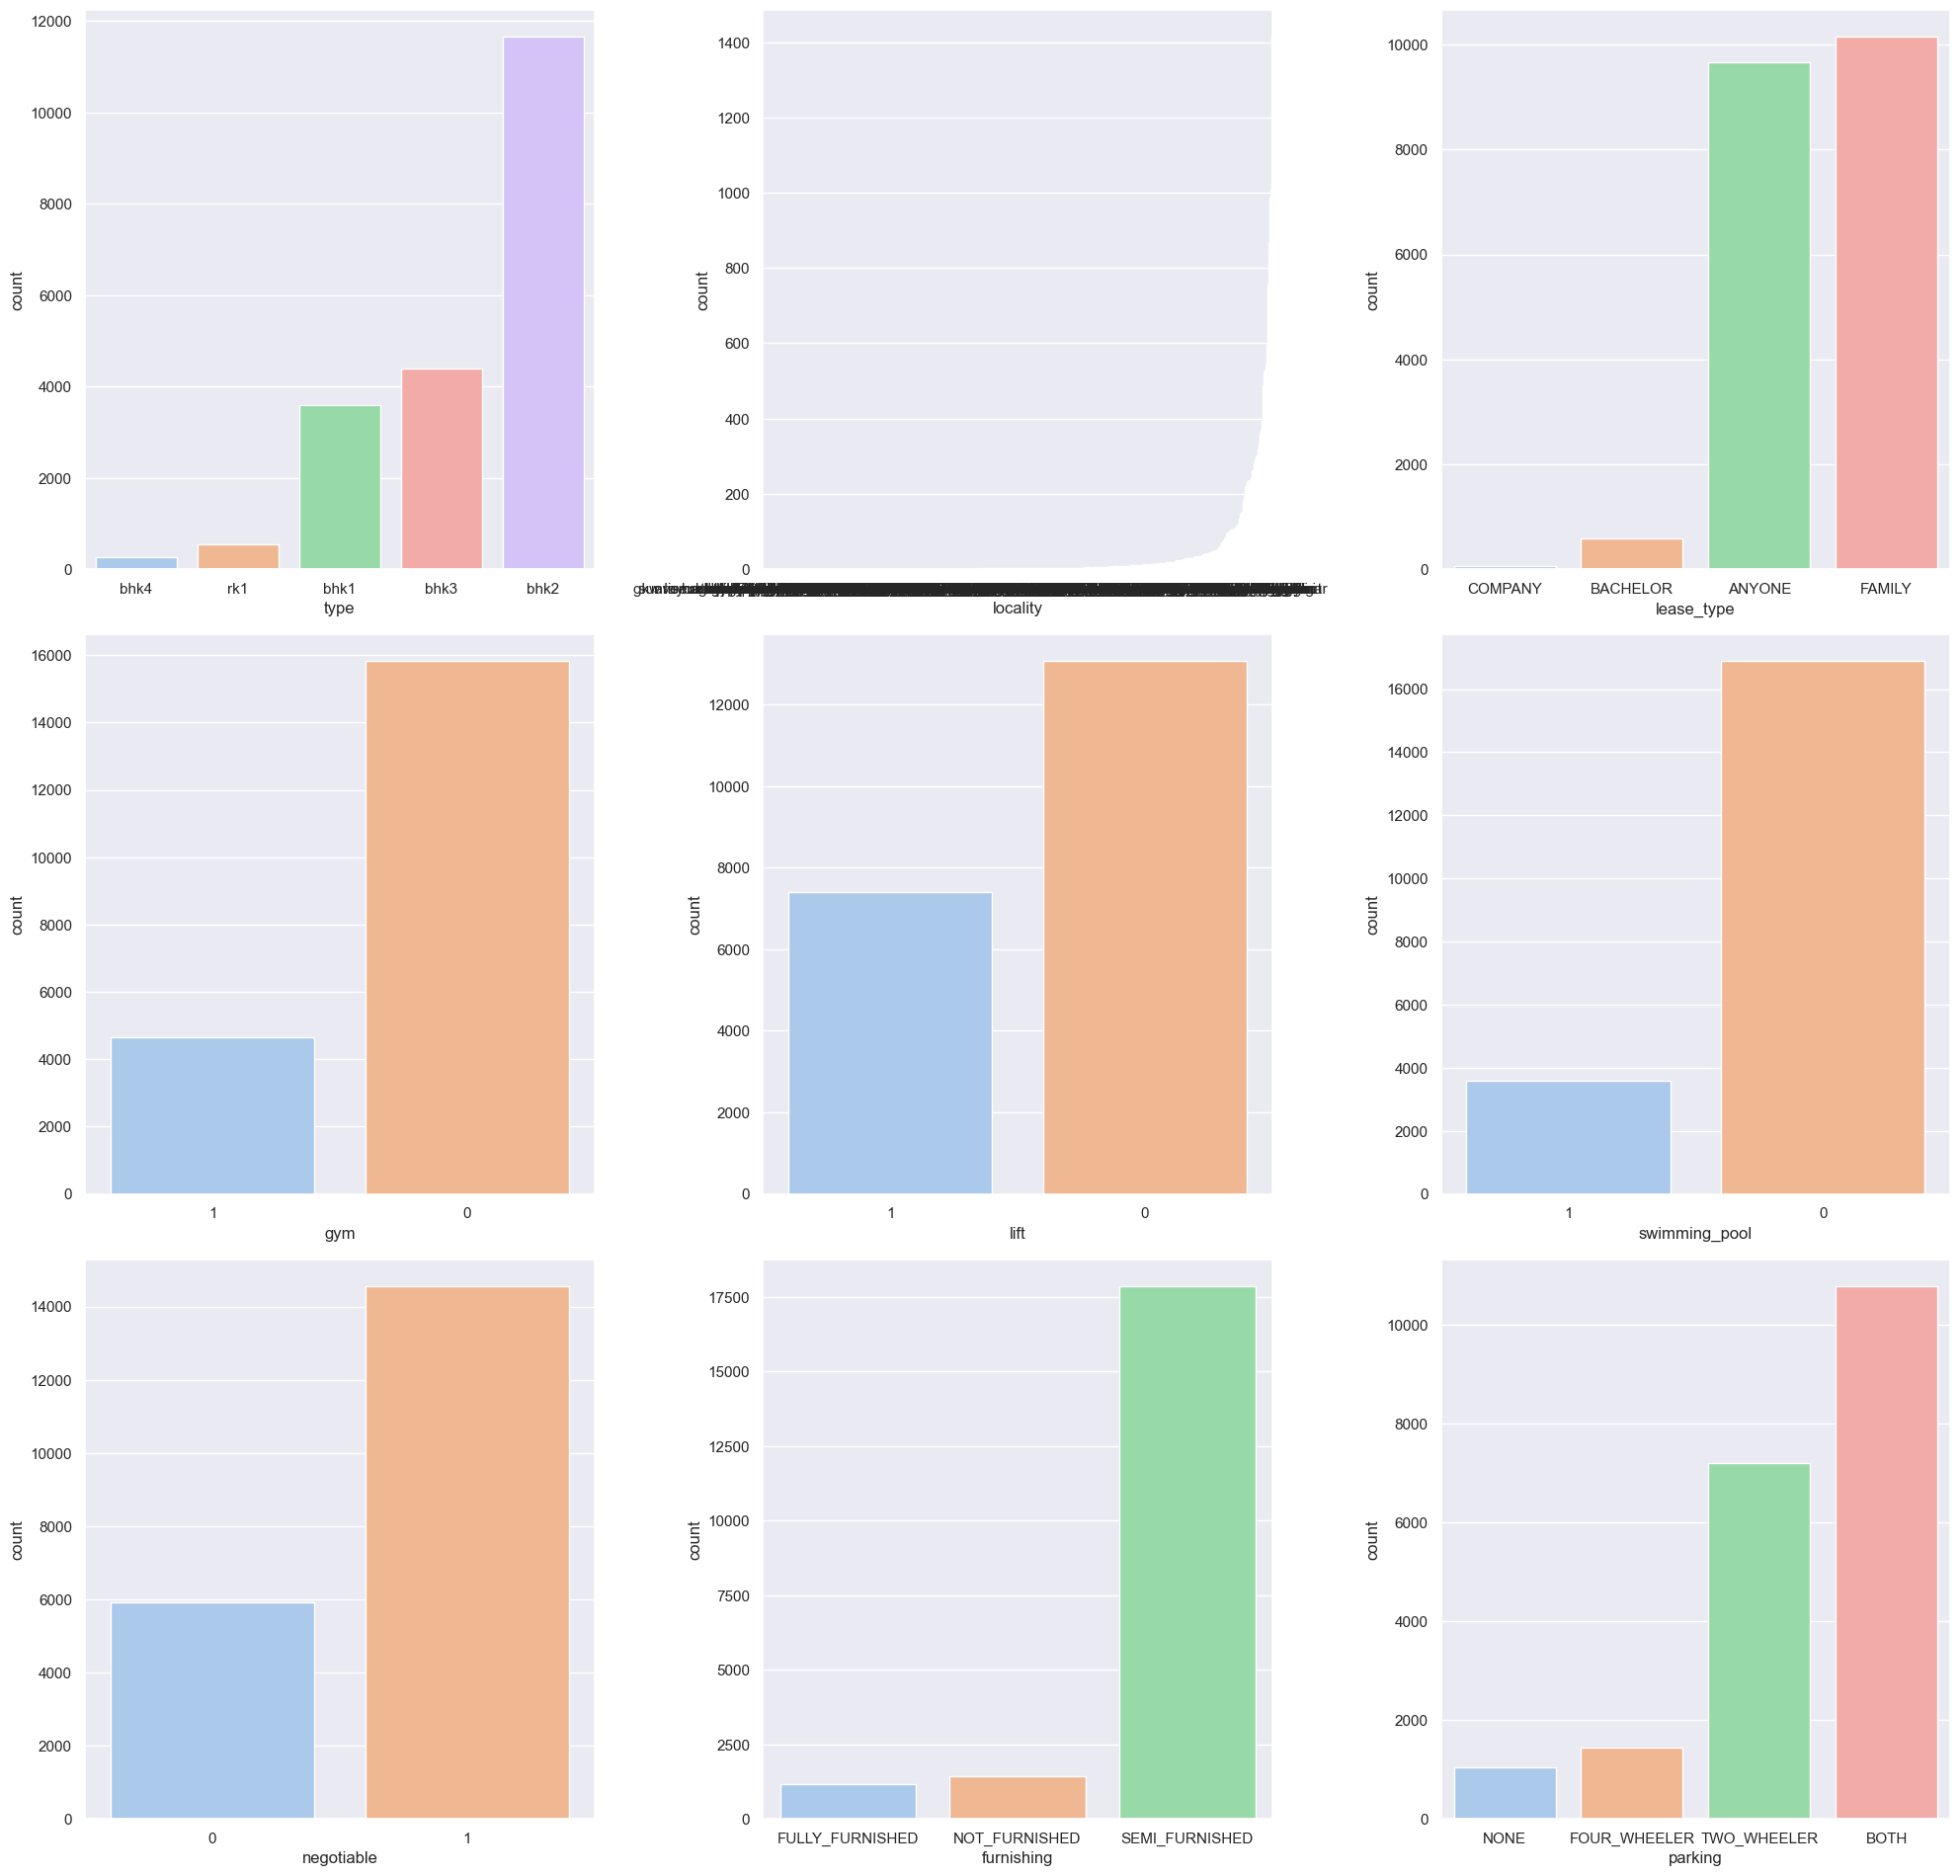

In [47]:
#plotting count plots for all the categorical columns
sns.set_theme(style='darkgrid',palette='pastel')
plt.figure(figsize=(20,25))

#1
plt.subplot(431)
sns.countplot(x=main_DF["type"],order= main_DF['type'].value_counts().index[::-1])
plt.xlabel='type'
plt.ylabel='count'
plt.title='rent according to type'

plt.subplot(432)
sns.countplot(x=main_DF["locality"],order= main_DF['locality'].value_counts().index[::-1])
plt.xlabel='locality'
plt.ylabel='count'
plt.title='rent according to locality'

plt.subplot(433)
sns.countplot(x=main_DF["lease_type"],order= main_DF['lease_type'].value_counts().index[::-1])
plt.xlabel='lease_type'
plt.ylabel='count'
plt.title='rent according to lease_type'

plt.subplot(434)
sns.countplot(x=main_DF["gym"],order= main_DF['gym'].value_counts().index[::-1])
plt.xlabel='gym'
plt.ylabel='count'
plt.title='rent according to gym'

plt.subplot(435)
sns.countplot(x=main_DF["lift"],order= main_DF['lift'].value_counts().index[::-1])
plt.xlabel='lift'
plt.ylabel='count'
plt.title='rent according to lift'

plt.subplot(436)
sns.countplot(x=main_DF["swimming_pool"],order= main_DF['swimming_pool'].value_counts().index[::-1])
plt.xlabel='swimming_pool'
plt.ylabel='count'
plt.title='rent according to swimming_pool'

plt.subplot(437)
sns.countplot(x=main_DF["negotiable"],order= main_DF['negotiable'].value_counts().index[::-1])
plt.xlabel='negotiable'
plt.ylabel='count'
plt.title='rent according to negotiable'

plt.subplot(438)
sns.countplot(x=main_DF["furnishing"],order= main_DF['furnishing'].value_counts().index[::-1])
plt.xlabel='furnishing'
plt.ylabel='count'
plt.title='rent according to furnishing'

plt.subplot(439)
sns.countplot(x=main_DF["parking"],order= main_DF['parking'].value_counts().index[::-1])
plt.xlabel='parking'
plt.ylabel='count'
plt.title='rent according to parking'


plt.tight_layout()





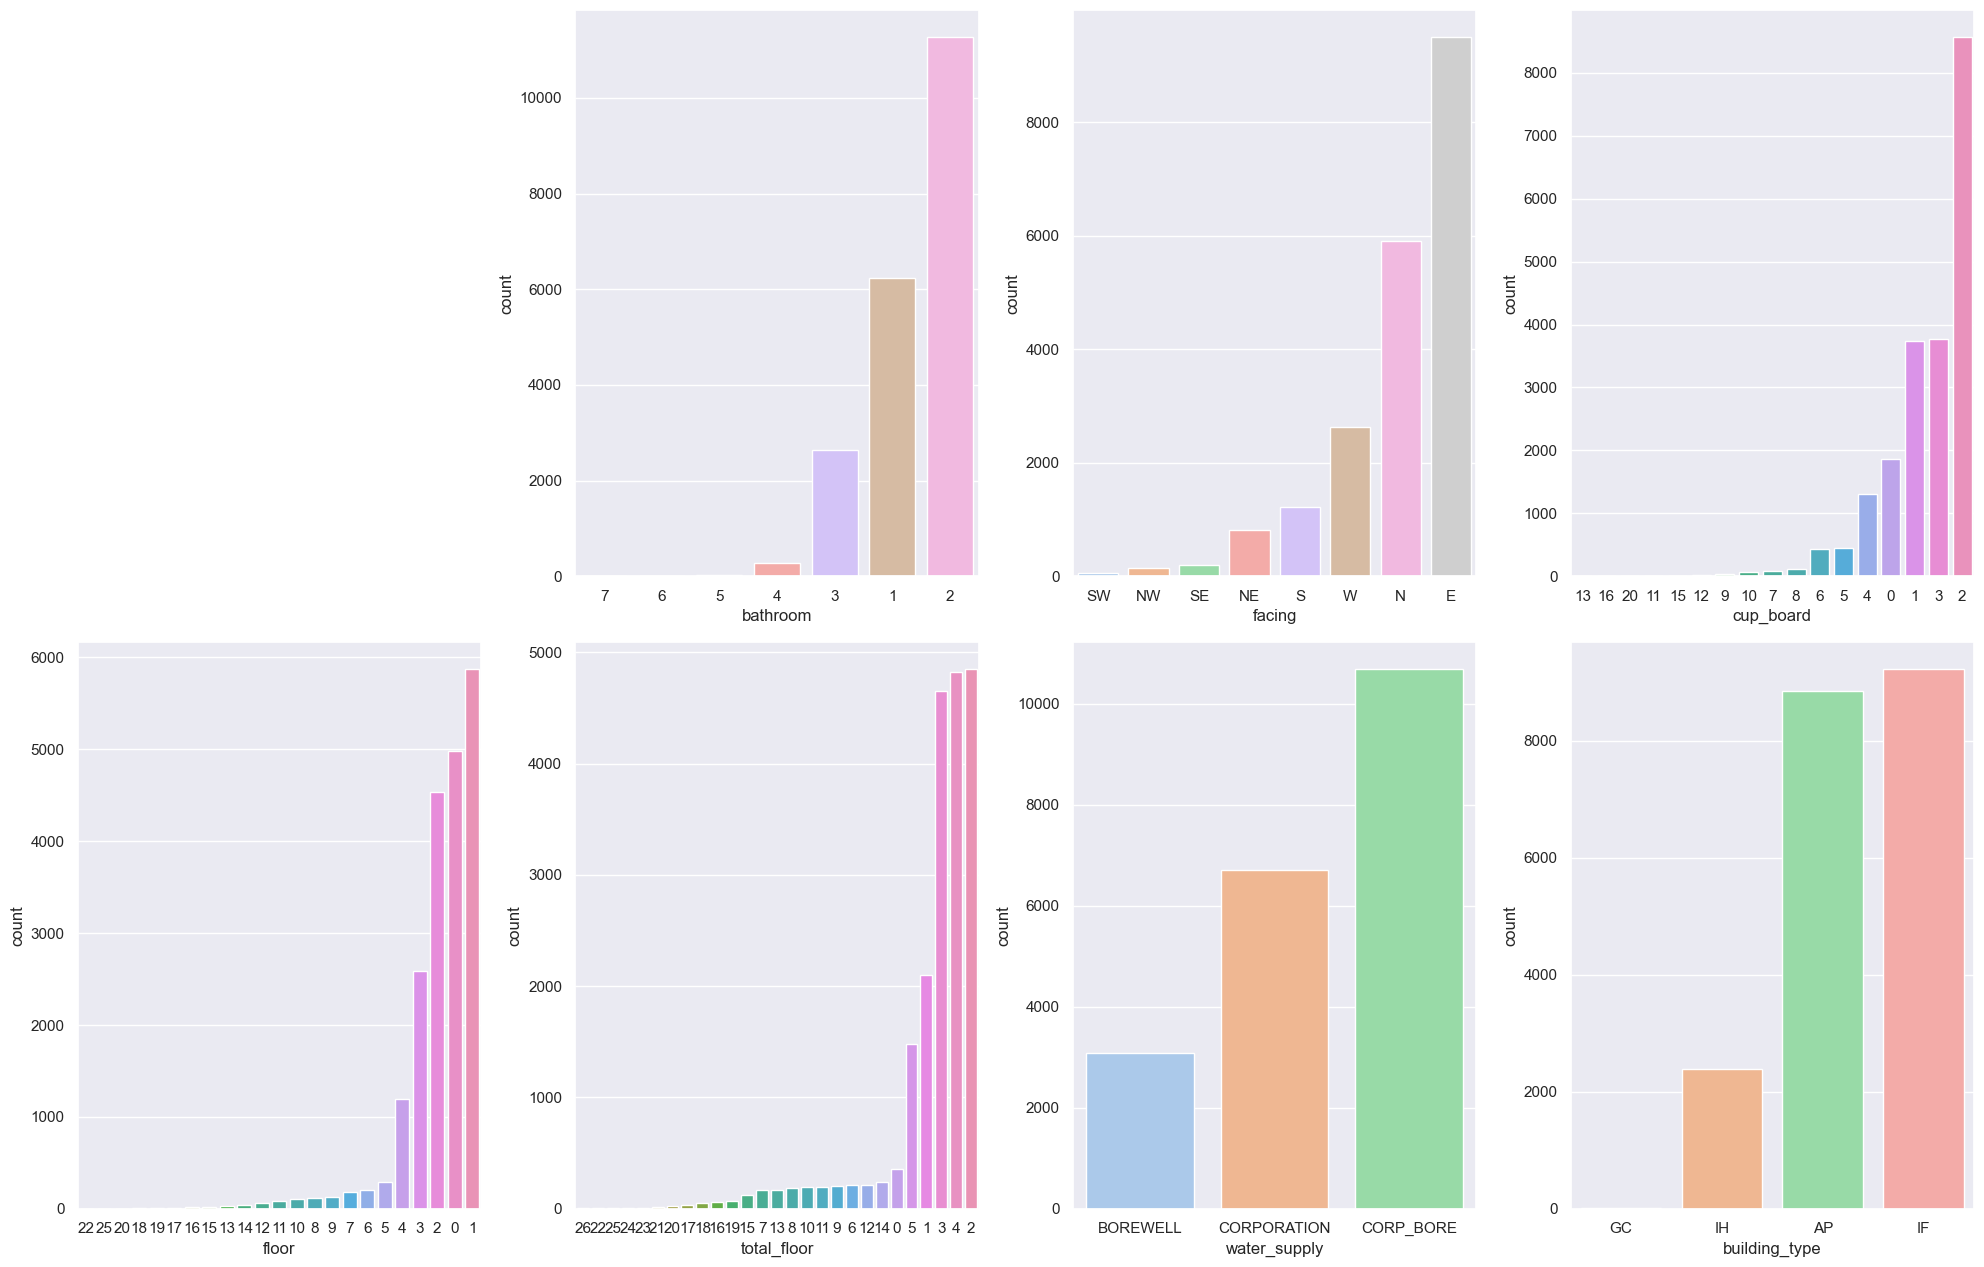

In [48]:
#2
#plotting count plots for all the categorical columns
sns.set_theme(style='darkgrid',palette='pastel')
plt.figure(figsize=(20,25))

plt.subplot(442)
sns.countplot(x=main_DF["bathroom"],order= main_DF['bathroom'].value_counts().index[::-1])
plt.xlabel='bathroom'
plt.ylabel='count'
plt.title='rent according to bathroom'

plt.subplot(443)
sns.countplot(x=main_DF["facing"],order= main_DF['facing'].value_counts().index[::-1])
plt.xlabel='facing'
plt.ylabel='count'
plt.title='rent according to facing'

plt.subplot(444)
sns.countplot(x=main_DF["cup_board"],order= main_DF['cup_board'].value_counts().index[::-1])
plt.xlabel='cup_board'
plt.ylabel='count'
plt.title='rent according to cup_board'

plt.subplot(445)
sns.countplot(x=main_DF["floor"],order= main_DF['floor'].value_counts().index[::-1])
plt.xlabel='floor'
plt.ylabel='count'
plt.title='rent according to floor'

plt.subplot(446)
sns.countplot(x=main_DF["total_floor"],order= main_DF['total_floor'].value_counts().index[::-1])
plt.xlabel='total_floor'
plt.ylabel='count'
plt.title='rent according to total_floor'

plt.subplot(447)
sns.countplot(x=main_DF["water_supply"],order= main_DF['water_supply'].value_counts().index[::-1])
plt.xlabel='water_supply'
plt.ylabel='count'
plt.title='rent according to water_supply'

plt.subplot(448)
sns.countplot(x=main_DF["building_type"],order= main_DF['building_type'].value_counts().index[::-1])
plt.xlabel='building_type'
plt.ylabel='count'
plt.title='rent according to building_type'



plt.tight_layout()


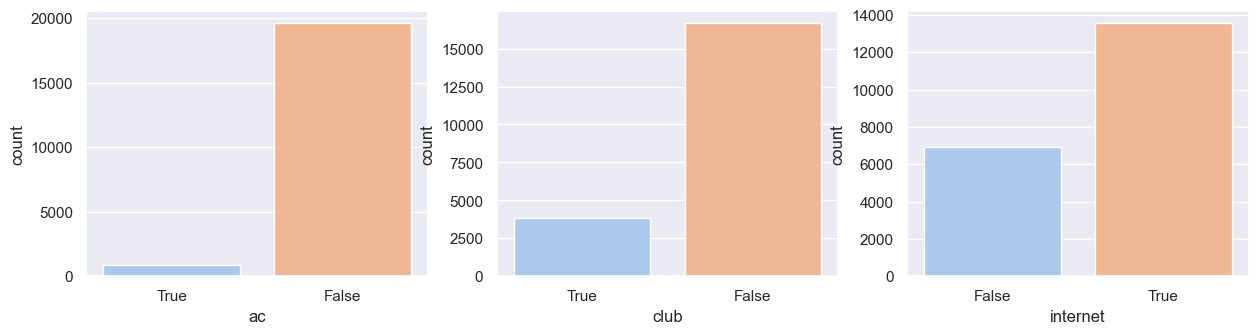

In [49]:
#plotting count plots for all the categorical columns
sns.set_theme(style='darkgrid',palette='pastel')
plt.figure(figsize=(15,20))

plt.subplot(531)
sns.countplot(x=main_DF["ac"],order= main_DF['ac'].value_counts().index[::-1])
plt.xlabel='ac'
plt.ylabel='count'
plt.title='rent according to ac'

# plt.subplot(453)
# sns.countplot(x=main_DF["balconies"],order= main_DF['balconies'].value_counts().index[::-1])
# plt.xlabel='balconies'
# plt.ylabel='count'
# plt.title='rent according to balconies'

plt.subplot(532)
sns.countplot(x=main_DF["club"],order= main_DF['club'].value_counts().index[::-1])
plt.xlabel='club'
plt.ylabel='count'
plt.title='rent according to club'

plt.subplot(533)
sns.countplot(x=main_DF["internet"],order= main_DF['internet'].value_counts().index[::-1])
plt.xlabel='internet'
plt.ylabel='count'
plt.title='rent according to internet'

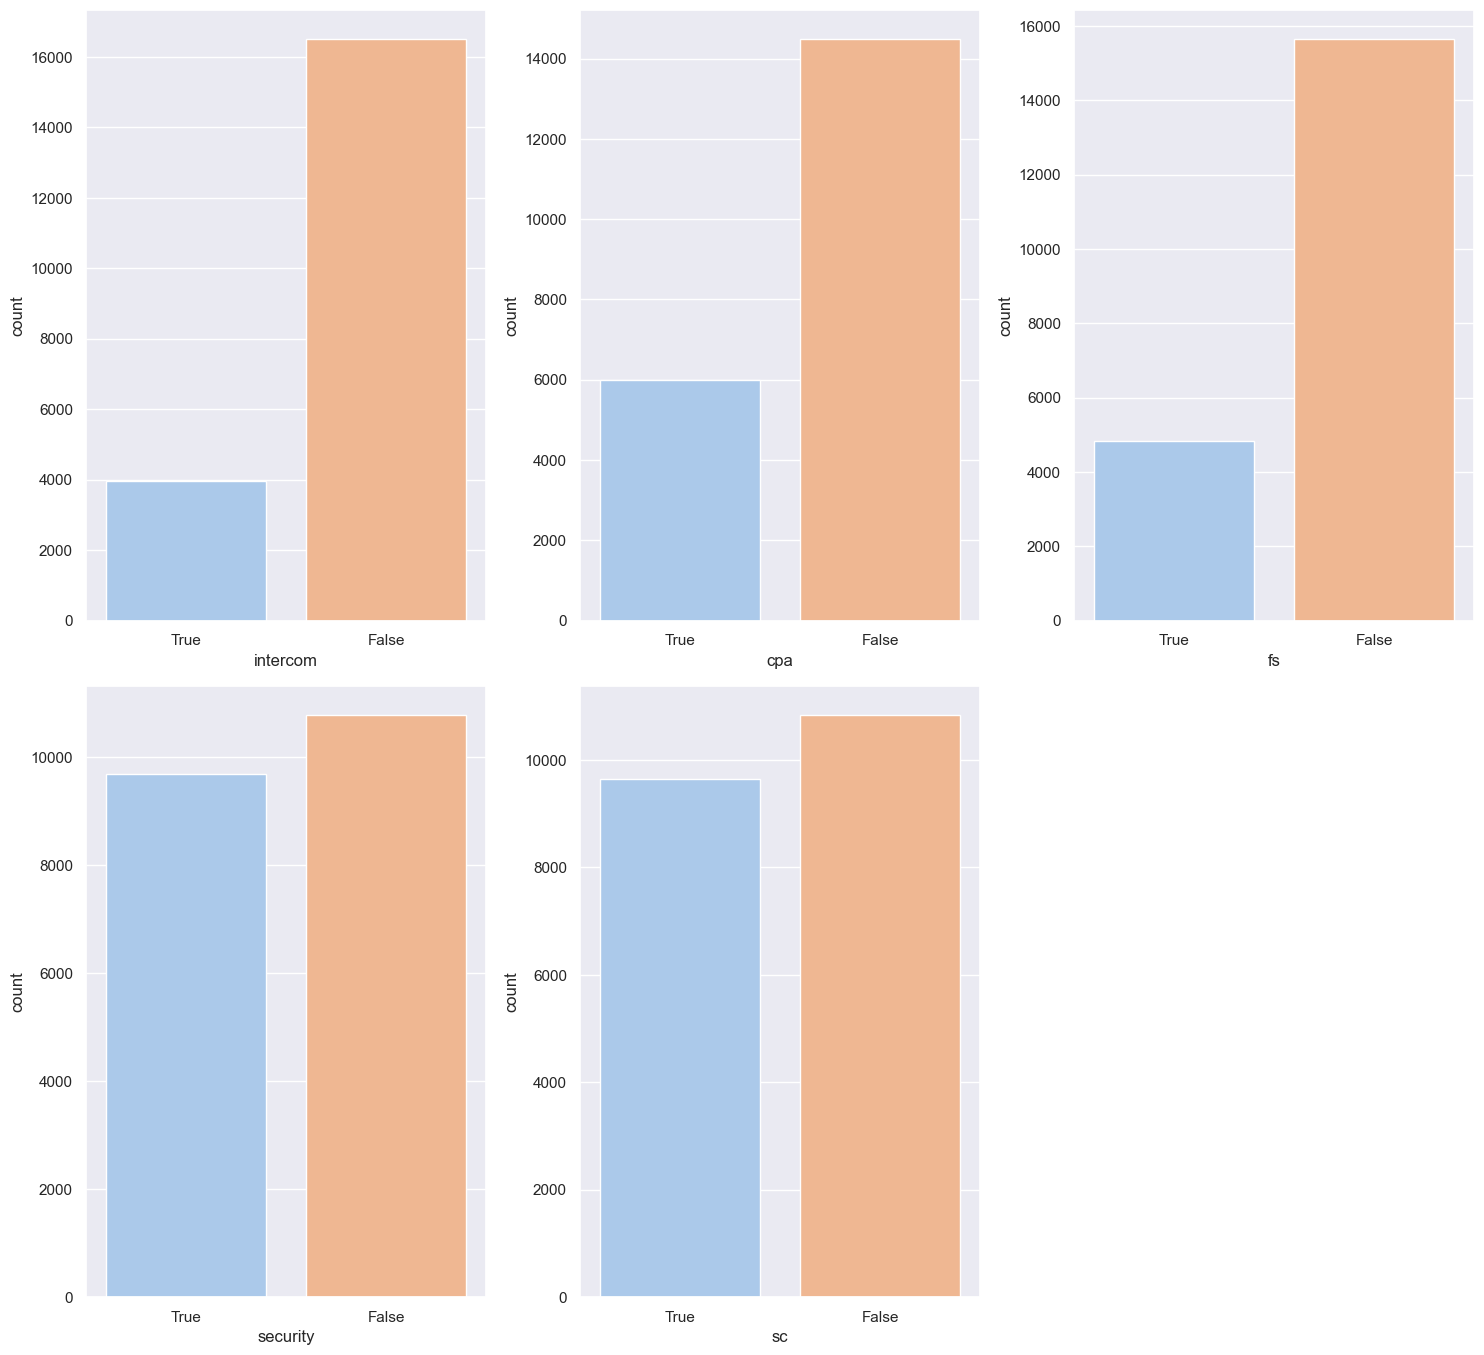

In [50]:
#3
#plotting count plots for all the categorical columns
sns.set_theme(style='darkgrid',palette='pastel')
plt.figure(figsize=(15,20))

plt.subplot(331)
sns.countplot(x=main_DF["intercom"],order= main_DF['intercom'].value_counts().index[::-1])
plt.xlabel='intercom'
plt.ylabel='count'
plt.title='rent according to intercom'

plt.subplot(332)
sns.countplot(x=main_DF["cpa"],order= main_DF['cpa'].value_counts().index[::-1])
plt.xlabel='cpa'
plt.ylabel='count'
plt.title='rent according to cpa'

plt.subplot(333)
sns.countplot(x=main_DF["fs"],order= main_DF['fs'].value_counts().index[::-1])
plt.xlabel='fs'
plt.ylabel='count'
plt.title='rent according to fs'

plt.subplot(334)
sns.countplot(x=main_DF["security"],order= main_DF['security'].value_counts().index[::-1])
plt.xlabel='security'
plt.ylabel='count'
plt.title='rent according to security'

plt.subplot(335)
sns.countplot(x=main_DF["sc"],order= main_DF['sc'].value_counts().index[::-1])
plt.xlabel='sc'
plt.ylabel='count'
plt.title='rent according to sc'

plt.tight_layout()


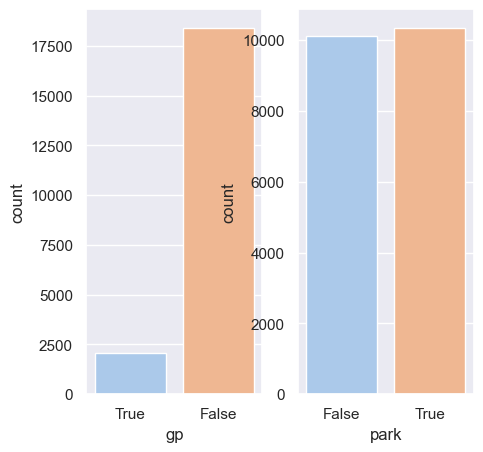

In [51]:
#4
#plotting count plots for all the categorical columns
sns.set_theme(style='darkgrid',palette='pastel')
plt.figure(figsize=(5,5))

plt.subplot(121)
sns.countplot(x=main_DF["gp"],order= main_DF['gp'].value_counts().index[::-1])
plt.xlabel='gp'
plt.ylabel='count'
plt.title='rent according to gp'

plt.subplot(122)
sns.countplot(x=main_DF["park"],order= main_DF['park'].value_counts().index[::-1])
plt.xlabel='park'
plt.ylabel='count'
plt.title='rent according to park'





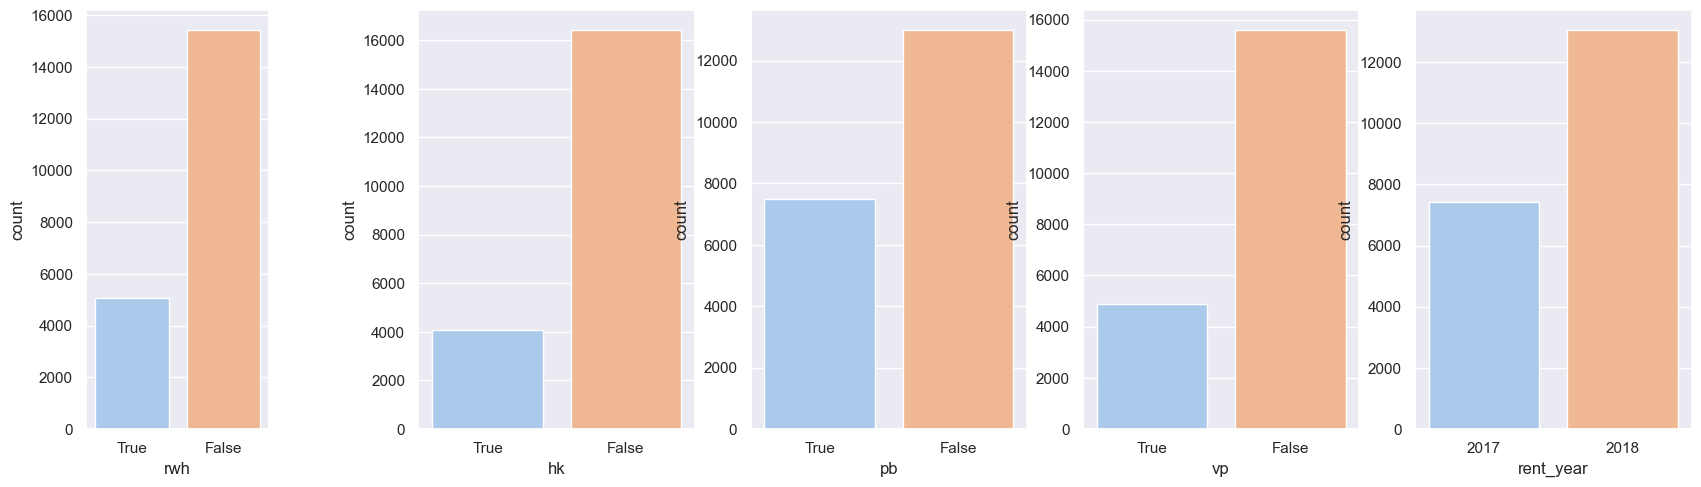

In [52]:

#plotting count plots for all the categorical columns
sns.set_theme(style='darkgrid',palette='pastel')
plt.figure(figsize=(25,25))

plt.subplot(491)
sns.countplot(x=main_DF["rwh"],order= main_DF['rwh'].value_counts().index[::-1])
plt.xlabel='rwh'
plt.ylabel='count'
plt.title='rent according to rwh'

plt.subplot(462)
sns.countplot(x=main_DF["hk"],order= main_DF['hk'].value_counts().index[::-1])
plt.xlabel='hk'
plt.ylabel='count'
plt.title='rent according to hk'

plt.subplot(463)
sns.countplot(x=main_DF["pb"],order= main_DF['pb'].value_counts().index[::-1])
plt.xlabel='pb'
plt.ylabel='count'
plt.title='rent according to pb'

plt.subplot(464)
sns.countplot(x=main_DF["vp"],order= main_DF['vp'].value_counts().index[::-1])
plt.xlabel='vp'
plt.ylabel='count'
plt.title='rent according to vp'

plt.subplot(465)
sns.countplot(x=main_DF["rent_year"],order= main_DF['rent_year'].value_counts().index[::-1])
plt.xlabel='rent_year'
plt.ylabel='count'
plt.title='rent according to rent_year'



In [53]:
main_DF.columns

Index(['type', 'locality', 'lease_type', 'gym', 'lift', 'swimming_pool',
       'negotiable', 'furnishing', 'parking', 'property_size', 'property_age',
       'bathroom', 'facing', 'cup_board', 'floor', 'total_floor',
       'water_supply', 'building_type', 'balconies', 'rent', 'internet', 'ac',
       'club', 'intercom', 'cpa', 'fs', 'security', 'sc', 'gp', 'park', 'rwh',
       'stp', 'hk', 'pb', 'vp', 'rent_year'],
      dtype='object')

In [54]:
#Plotting Barplot for categorical columns vs target (rent)

In [55]:
#orders for all the barplots in ascending order
type_order = main_DF.groupby('type')['rent'].mean().reset_index().sort_values('rent')['type']
locality_order = main_DF.groupby('locality')['rent'].mean().reset_index().sort_values('rent')['locality']
lease_type_order = main_DF.groupby('lease_type')['rent'].mean().reset_index().sort_values('rent')['lease_type']
gym_order = main_DF.groupby('gym')['rent'].mean().reset_index().sort_values('rent')['gym']
lift_order = main_DF.groupby('lift')['rent'].mean().reset_index().sort_values('rent')['lift']
swimming_pool_order = main_DF.groupby('swimming_pool')['rent'].mean().reset_index().sort_values('rent')['swimming_pool']
negotiable_order = main_DF.groupby('negotiable')['rent'].mean().reset_index().sort_values('rent')['negotiable']
furnishing_order = main_DF.groupby('furnishing')['rent'].mean().reset_index().sort_values('rent')['furnishing']
parking_order = main_DF.groupby('parking')['rent'].mean().reset_index().sort_values('rent')['parking']
bathroom_order = main_DF.groupby('bathroom')['rent'].mean().reset_index().sort_values('rent')['bathroom']
facing_order = main_DF.groupby('facing')['rent'].mean().reset_index().sort_values('rent')['facing']
cup_board_order = main_DF.groupby('cup_board')['rent'].mean().reset_index().sort_values('rent')['cup_board']
floor_order = main_DF.groupby('floor')['rent'].mean().reset_index().sort_values('rent')['floor']
total_floor_order = main_DF.groupby('total_floor')['rent'].mean().reset_index().sort_values('rent')['total_floor']
water_supply_order = main_DF.groupby('water_supply')['rent'].mean().reset_index().sort_values('rent')['water_supply']
building_type_order = main_DF.groupby('building_type')['rent'].mean().reset_index().sort_values('rent')['building_type']
internet_order = main_DF.groupby('internet')['rent'].mean().reset_index().sort_values('rent')['internet']
ac_order = main_DF.groupby('ac')['rent'].mean().reset_index().sort_values('rent')['ac']
club_order = main_DF.groupby('club')['rent'].mean().reset_index().sort_values('rent')['club']
intercom_order = main_DF.groupby('intercom')['rent'].mean().reset_index().sort_values('rent')['intercom']
cpa_order = main_DF.groupby('cpa')['rent'].mean().reset_index().sort_values('rent')['cpa']
fs_order = main_DF.groupby('fs')['rent'].mean().reset_index().sort_values('rent')['fs']
security_order = main_DF.groupby('security')['rent'].mean().reset_index().sort_values('rent')['security']
sc_order = main_DF.groupby('sc')['rent'].mean().reset_index().sort_values('rent')['sc']
gp_order = main_DF.groupby('gp')['rent'].mean().reset_index().sort_values('rent')['gp']
park_order = main_DF.groupby('park')['rent'].mean().reset_index().sort_values('rent')['park']
rwh_order = main_DF.groupby('rwh')['rent'].mean().reset_index().sort_values('rent')['rwh']
stp_order = main_DF.groupby('stp')['rent'].mean().reset_index().sort_values('rent')['stp']
hk_order = main_DF.groupby('hk')['rent'].mean().reset_index().sort_values('rent')['hk']
pb_order = main_DF.groupby('pb')['rent'].mean().reset_index().sort_values('rent')['pb']
vp_order = main_DF.groupby('vp')['rent'].mean().reset_index().sort_values('rent')['vp']
rent_year_order = main_DF.groupby('rent_year')['rent'].mean().reset_index().sort_values('rent')['rent_year']

In [56]:
main_DF.columns

Index(['type', 'locality', 'lease_type', 'gym', 'lift', 'swimming_pool',
       'negotiable', 'furnishing', 'parking', 'property_size', 'property_age',
       'bathroom', 'facing', 'cup_board', 'floor', 'total_floor',
       'water_supply', 'building_type', 'balconies', 'rent', 'internet', 'ac',
       'club', 'intercom', 'cpa', 'fs', 'security', 'sc', 'gp', 'park', 'rwh',
       'stp', 'hk', 'pb', 'vp', 'rent_year'],
      dtype='object')

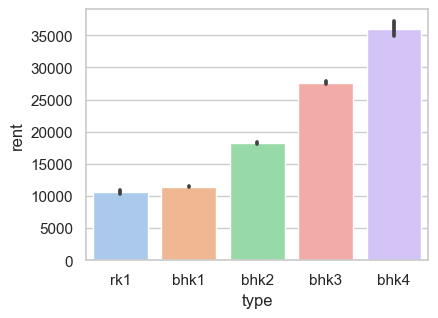

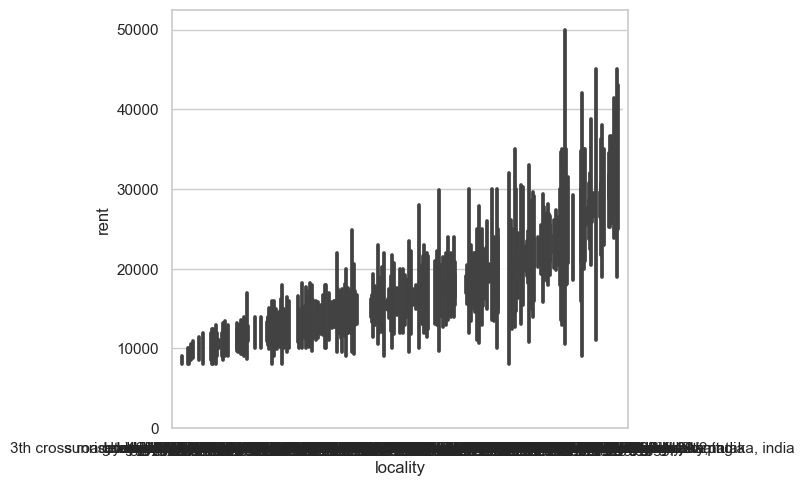

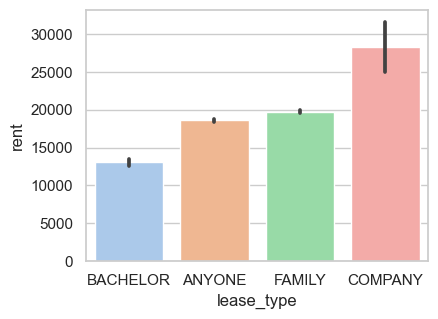

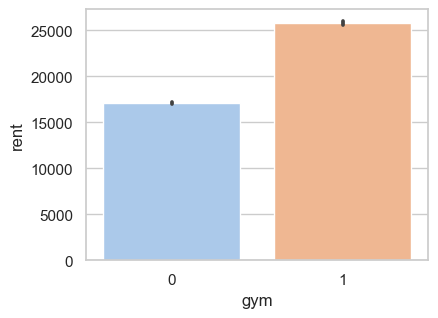

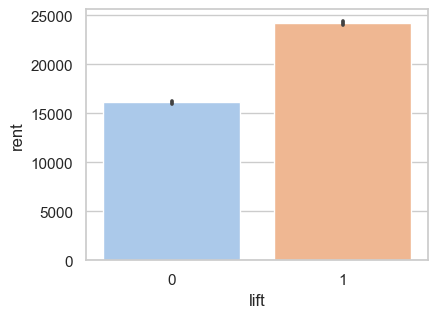

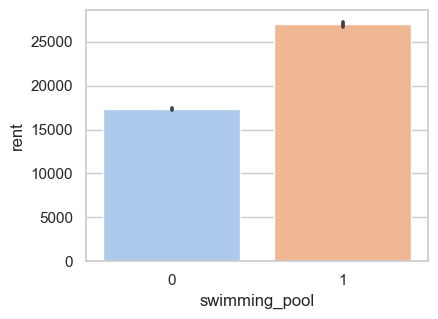

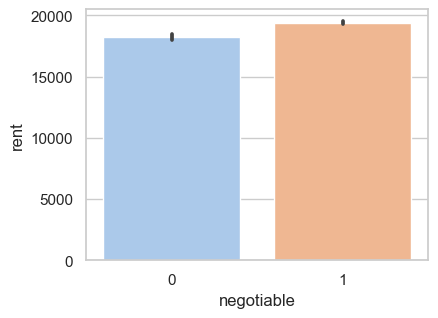

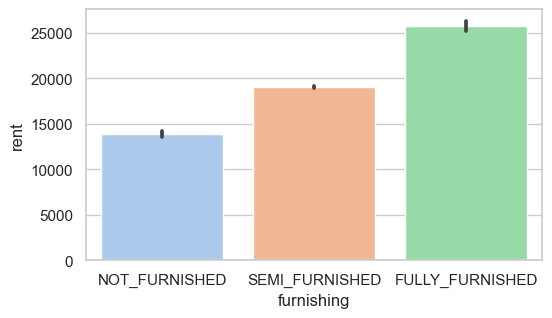

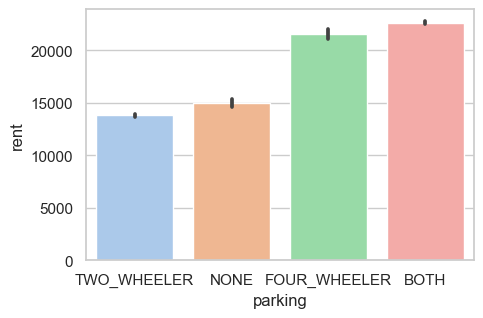

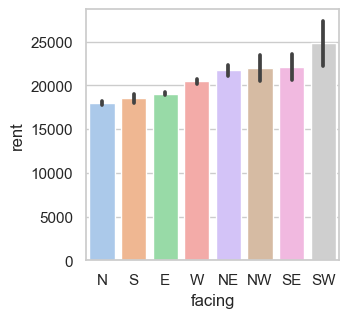

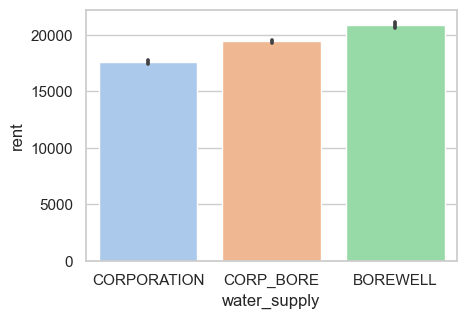

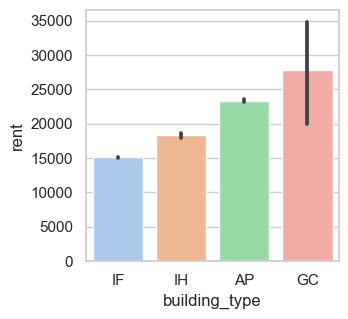

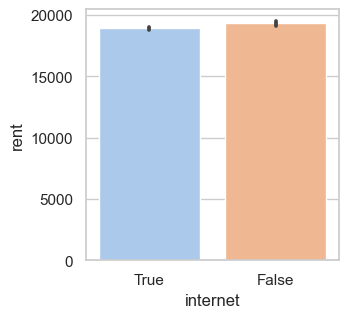

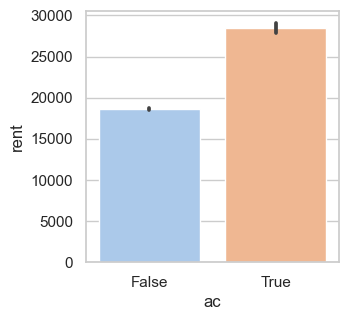

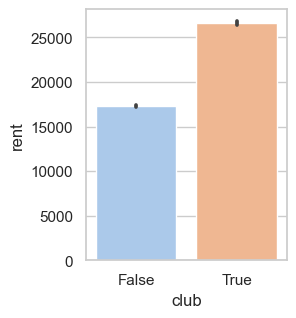

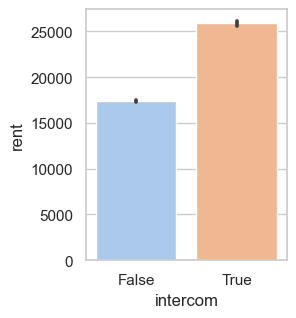

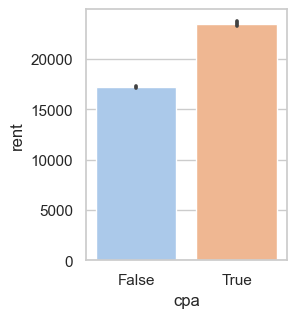

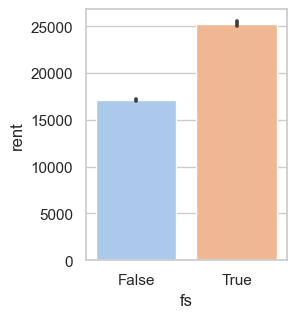

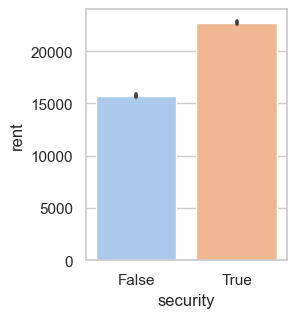

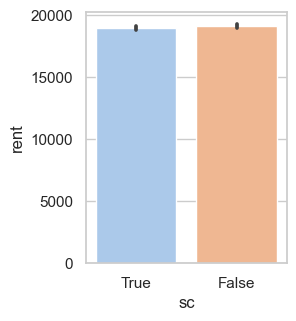

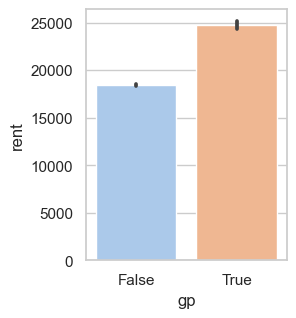

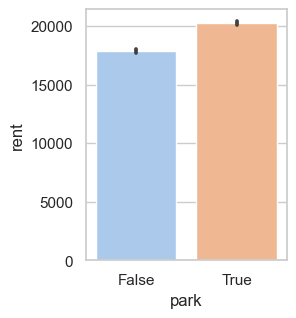

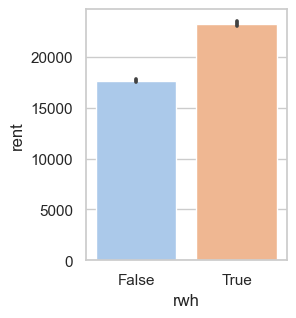

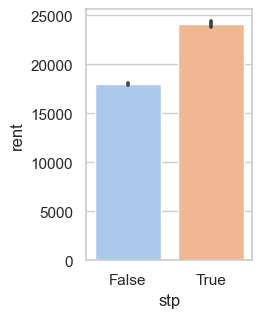

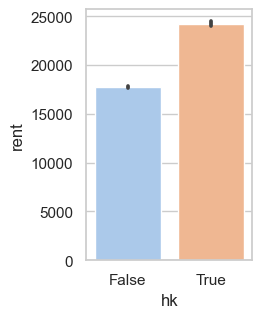

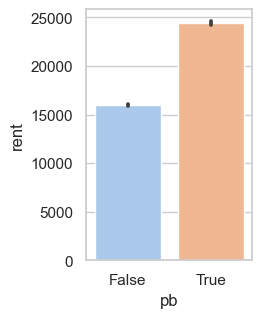

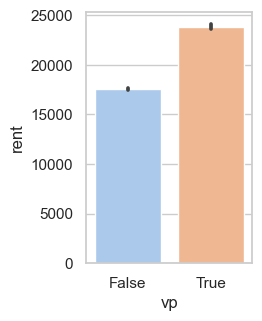

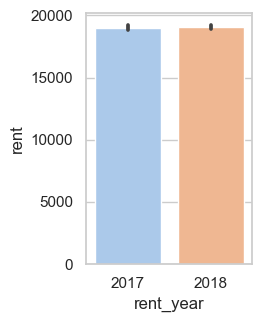

<Figure size 640x480 with 0 Axes>

In [57]:
#For categoricals
sns.set_theme(style='whitegrid',palette='pastel')
plt.figure(figsize=(15,15))

plt.subplot(431)
sns.barplot(data=main_DF,x='type',y='rent', order = type_order)
plt.show()

plt.figure(figsize=(20,25))
plt.subplot(432)
sns.barplot(data=main_DF,x='locality',y='rent', order = locality_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(433)
sns.barplot(data=main_DF,x='lease_type',y='rent', order = lease_type_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(434)
sns.barplot(data=main_DF,x='gym',y='rent', order = gym_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(435)
sns.barplot(data=main_DF,x='lift',y='rent', order = lift_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(436)
sns.barplot(data=main_DF,x='swimming_pool',y='rent', order = swimming_pool_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(437)
sns.barplot(data=main_DF,x='negotiable',y='rent', order = negotiable_order)
plt.show()

plt.figure(figsize=(20,15))
plt.subplot(438)
sns.barplot(data=main_DF,x='furnishing',y='rent', order = furnishing_order)
plt.show()

plt.figure(figsize=(17,15))
plt.subplot(439)
sns.barplot(data=main_DF,x='parking',y='rent', order = parking_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(442)
sns.barplot(data=main_DF,x='facing',y='rent', order = facing_order)
plt.show()

plt.figure(figsize=(22,15))
plt.subplot(446)
sns.barplot(data=main_DF,x='water_supply',y='rent', order = water_supply_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(447)
sns.barplot(data=main_DF,x='building_type',y='rent', order = building_type_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(448)
sns.barplot(data=main_DF,x='internet',y='rent', order = internet_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(449)
sns.barplot(data=main_DF,x='ac',y='rent', order = ac_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(451)
sns.barplot(data=main_DF,x='club',y='rent', order = club_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(452)
sns.barplot(data=main_DF,x='intercom',y='rent', order = intercom_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(453)
sns.barplot(data=main_DF,x='cpa',y='rent', order = cpa_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(454)
sns.barplot(data=main_DF,x='fs',y='rent', order = fs_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(455)
sns.barplot(data=main_DF,x='security',y='rent', order = security_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(456)
sns.barplot(data=main_DF,x='sc',y='rent', order = sc_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(457)
sns.barplot(data=main_DF,x='gp',y='rent', order = gp_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(458)
sns.barplot(data=main_DF,x='park',y='rent', order = park_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(459)
sns.barplot(data=main_DF,x='rwh',y='rent', order = rwh_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(461)
sns.barplot(data=main_DF,x='stp',y='rent', order = stp_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(462)
sns.barplot(data=main_DF,x='hk',y='rent', order = hk_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(463)
sns.barplot(data=main_DF,x='pb',y='rent', order = pb_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(464)
sns.barplot(data=main_DF,x='vp',y='rent', order = vp_order)
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(465)
sns.barplot(data=main_DF,x='rent_year',y='rent', order = rent_year_order)
plt.show()

plt.tight_layout()



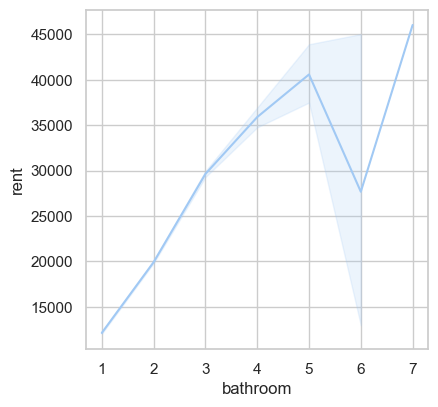

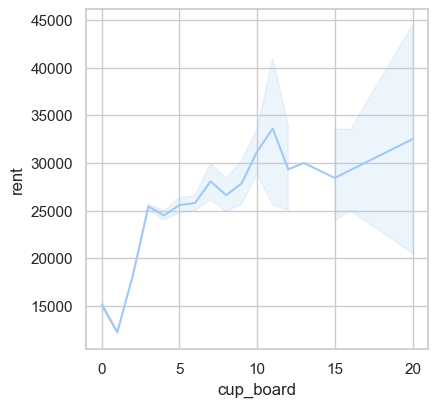

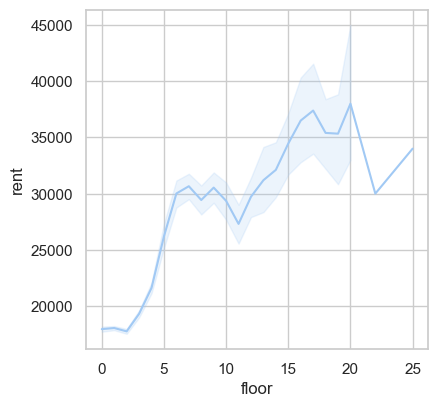

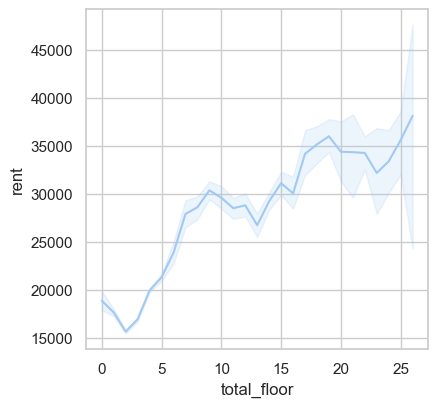

<Figure size 640x480 with 0 Axes>

In [58]:
#For numericals
sns.set_theme(style='whitegrid',palette='pastel')
plt.figure(figsize=(15,15))
plt.subplot(331)
sns.lineplot(data=main_DF,x='bathroom',y='rent')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(332)
sns.lineplot(data=main_DF,x='cup_board',y='rent')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(333)
sns.lineplot(data=main_DF,x='floor',y='rent')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(334)
sns.lineplot(data=main_DF,x='total_floor',y='rent')
plt.show()

plt.tight_layout()



# Remove unwanted columns

In [59]:
del main_DF['sc']
del main_DF['internet']
del main_DF['rent_year']

In [60]:
main_DF

,type,locality,lease_type,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,water_supply,building_type,balconies,rent,ac,club,intercom,cpa,fs,security,gp,park,rwh,stp,hk,pb,vp
0,bhk2,agaram,FAMILY,1,1,1,0,SEMI_FURNISHED,BOTH,1250,25,2,E,2,6,12,CORP_BORE,AP,2,40000,False,True,True,True,True,True,True,False,True,True,False,True,True
1,bhk2,bellandur,ANYONE,0,1,0,1,SEMI_FURNISHED,BOTH,1400,4,2,NE,2,3,4,CORPORATION,AP,2,22000,False,False,False,False,False,True,False,True,True,True,False,True,True
2,bhk3,thiruvanmiyur,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1350,6,3,E,3,1,5,CORP_BORE,AP,3,28000,False,False,False,True,False,False,False,True,False,False,False,True,True
3,bhk1,attiguppe,FAMILY,0,0,0,1,SEMI_FURNISHED,TWO_WHEELER,600,3,1,E,1,1,2,CORPORATION,IH,0,8000,False,False,False,False,False,False,False,False,False,False,False,False,False
4,bhk3,kodihalli,FAMILY,0,0,0,1,SEMI_FURNISHED,BOTH,1500,15,3,E,4,0,0,CORPORATION,IH,1,45000,False,False,False,True,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20495,bhk2,rr nagar,ANYONE,1,1,1,1,SEMI_FURNISHED,BOTH,1650,1,3,E,3,4,4,BOREWELL,AP,2,25000,False,False,True,True,False,True,False,False,False,False,False,True,True
20496,bhk2,koramangala,ANYONE,0,0,0,1,SEMI_FURNISHED,BOTH,1000,10,2,N,2,1,2,CORPORATION,IH,2,30000,False,False,False,False,False,False,False,True,True,False,False,False,False
20497,bhk2,kumaraswamy layout,FAMILY,1,1,0,1,SEMI_FURNISHED,BOTH,1000,0,2,W,2,5,5,BOREWELL,AP,2,16000,False,True,False,True,False,True,False,True,False,False,False,True,False
20498,bhk2,indira nagar,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1000,5,2,E,2,2,4,CORP_BORE,AP,3,30000,False,False,False,True,True,True,False,True,False,False,True,True,True


# Preprocessing and Encoding variables

In [61]:
# import pandas as pd

# # Assuming you have a DataFrame called main_DF with a 'locality' column

# # Step 1: Calculate the frequency of each category
locality_counts = main_DF['locality'].value_counts()

# # # Step 2: Sort the categories by their frequency in ascending order
sorted_localities = locality_counts.sort_index()

# # Step 3: Create a mapping dictionary with the sorted categories and frequencies
locality_encoding = dict(zip(sorted_localities.index, range(1, len(sorted_localities) + 1)))

# # Step 4: Encode the 'locality' column using the sorted frequencies
main_DF['locality'] = main_DF['locality'].map(locality_encoding)


/var/folders/2s/__02zny56tvcq0dmnnrdpgd00000gn/T/ipykernel_87425/1109530606.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_DF['locality'] = main_DF['locality'].map(locality_encoding)


In [62]:
main_DF

,type,locality,lease_type,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,water_supply,building_type,balconies,rent,ac,club,intercom,cpa,fs,security,gp,park,rwh,stp,hk,pb,vp
0,bhk2,14,FAMILY,1,1,1,0,SEMI_FURNISHED,BOTH,1250,25,2,E,2,6,12,CORP_BORE,AP,2,40000,False,True,True,True,True,True,True,False,True,True,False,True,True
1,bhk2,66,ANYONE,0,1,0,1,SEMI_FURNISHED,BOTH,1400,4,2,NE,2,3,4,CORPORATION,AP,2,22000,False,False,False,False,False,True,False,True,True,True,False,True,True
2,bhk3,519,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1350,6,3,E,3,1,5,CORP_BORE,AP,3,28000,False,False,False,True,False,False,False,True,False,False,False,True,True
3,bhk1,40,FAMILY,0,0,0,1,SEMI_FURNISHED,TWO_WHEELER,600,3,1,E,1,1,2,CORPORATION,IH,0,8000,False,False,False,False,False,False,False,False,False,False,False,False,False
4,bhk3,282,FAMILY,0,0,0,1,SEMI_FURNISHED,BOTH,1500,15,3,E,4,0,0,CORPORATION,IH,1,45000,False,False,False,True,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20495,bhk2,447,ANYONE,1,1,1,1,SEMI_FURNISHED,BOTH,1650,1,3,E,3,4,4,BOREWELL,AP,2,25000,False,False,True,True,False,True,False,False,False,False,False,True,True
20496,bhk2,288,ANYONE,0,0,0,1,SEMI_FURNISHED,BOTH,1000,10,2,N,2,1,2,CORPORATION,IH,2,30000,False,False,False,False,False,False,False,True,True,False,False,False,False
20497,bhk2,300,FAMILY,1,1,0,1,SEMI_FURNISHED,BOTH,1000,0,2,W,2,5,5,BOREWELL,AP,2,16000,False,True,False,True,False,True,False,True,False,False,False,True,False
20498,bhk2,218,FAMILY,0,1,0,0,SEMI_FURNISHED,BOTH,1000,5,2,E,2,2,4,CORP_BORE,AP,3,30000,False,False,False,True,True,True,False,True,False,False,True,True,True


In [63]:
main_DF.furnishing.unique()

array(['SEMI_FURNISHED', 'FULLY_FURNISHED', 'NOT_FURNISHED'], dtype=object)

In [64]:
main_DF['type'] = main_DF['type'].map({'rk1':0,'bhk1':0,'bhk2':1,'bhk3':2,'bhk4':3})
main_DF['furnishing'] = main_DF['furnishing'].map({'NOT_FURNISHED':0,'SEMI_FURNISHED':1,'FULLY_FURNISHED':2})
main_DF['parking'] = main_DF['parking'].map({'TWO_WHEELER':0,'NONE':1,'FOUR_WHEELER':7,'BOTH':8})
main_DF['facing'] = main_DF['facing'].map({'N':0,'S':1,'E':2,'W':4,'NE':6,'NW':6,'SE':6,'SW':10})
main_DF['water_supply'] = main_DF['water_supply'].map({'CORPORATION':0,'CORP_BORE':1,'BOREWELL':2})
main_DF = pd.get_dummies(main_DF, columns = ['building_type'])

/var/folders/2s/__02zny56tvcq0dmnnrdpgd00000gn/T/ipykernel_87425/3598862573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_DF['type'] = main_DF['type'].map({'rk1':0,'bhk1':0,'bhk2':1,'bhk3':2,'bhk4':3})
/var/folders/2s/__02zny56tvcq0dmnnrdpgd00000gn/T/ipykernel_87425/3598862573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_DF['furnishing'] = main_DF['furnishing'].map({'NOT_FURNISHED':0,'SEMI_FURNISHED':1,'FULLY_FURNISHED':2})
/var/folders/2s/__02zny56tvcq0dmnnrdpgd00000gn/T/ipykernel_87

In [65]:
main_DF['ac'] = main_DF['ac'].map({False:0,True:1})
main_DF['club'] = main_DF['club'].map({False:0,True:1})
main_DF['intercom'] = main_DF['intercom'].map({False:0,True:1})
main_DF['cpa'] = main_DF['cpa'].map({False:0,True:1})
main_DF['fs'] = main_DF['fs'].map({False:0,True:1})
main_DF['security'] = main_DF['security'].map({False:0,True:1})
main_DF['gp'] = main_DF['gp'].map({False:0,True:1})
main_DF['park'] = main_DF['park'].map({False:0,True:1})
main_DF['rwh'] = main_DF['rwh'].map({False:0,True:1})
main_DF['stp'] = main_DF['stp'].map({False:0,True:1})
main_DF['hk'] = main_DF['hk'].map({False:0,True:1})
main_DF['pb'] = main_DF['pb'].map({False:0,True:1})
main_DF['vp'] = main_DF['vp'].map({False:0,True:1})

In [66]:
main_DF = pd.get_dummies(main_DF, columns = ['lease_type'])

In [67]:
main_DF.head(5)

,type,locality,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,water_supply,balconies,rent,ac,club,intercom,cpa,fs,security,gp,park,rwh,stp,hk,pb,vp,building_type_AP,building_type_GC,building_type_IF,building_type_IH,lease_type_ANYONE,lease_type_BACHELOR,lease_type_COMPANY,lease_type_FAMILY
0,1,14,1,1,1,0,1,8,1250,25,2,2,2,6,12,1,2,40000,0,1,1,1,1,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1
1,1,66,0,1,0,1,1,8,1400,4,2,6,2,3,4,0,2,22000,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,1,0,0,0
2,2,519,0,1,0,0,1,8,1350,6,3,2,3,1,5,1,3,28000,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1
3,0,40,0,0,0,1,1,0,600,3,1,2,1,1,2,0,0,8000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,2,282,0,0,0,1,1,8,1500,15,3,2,4,0,0,0,1,45000,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1


# Splitting Data into Input and Output

In [68]:
X = main_DF.drop('rent',axis=1)
y = main_DF['rent']

In [69]:
X

,type,locality,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,water_supply,balconies,ac,club,intercom,cpa,fs,security,gp,park,rwh,stp,hk,pb,vp,building_type_AP,building_type_GC,building_type_IF,building_type_IH,lease_type_ANYONE,lease_type_BACHELOR,lease_type_COMPANY,lease_type_FAMILY
0,1,14,1,1,1,0,1,8,1250,25,2,2,2,6,12,1,2,0,1,1,1,1,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1
1,1,66,0,1,0,1,1,8,1400,4,2,6,2,3,4,0,2,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,1,0,0,0
2,2,519,0,1,0,0,1,8,1350,6,3,2,3,1,5,1,3,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1
3,0,40,0,0,0,1,1,0,600,3,1,2,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,2,282,0,0,0,1,1,8,1500,15,3,2,4,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20495,1,447,1,1,1,1,1,8,1650,1,3,2,3,4,4,2,2,0,0,1,1,0,1,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0
20496,1,288,0,0,0,1,1,8,1000,10,2,0,2,1,2,0,2,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0
20497,1,300,1,1,0,1,1,8,1000,0,2,4,2,5,5,2,2,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
20498,1,218,0,1,0,0,1,8,1000,5,2,2,2,2,4,1,3,0,0,0,1,1,1,0,1,0,0,1,1,1,1,0,0,0,0,0,0,1


In [70]:
y

0        40000
1        22000
2        28000
3         8000
4        45000
         ...  
20495    25000
20496    30000
20497    16000
20498    30000
20499     8500
Name: rent, Length: 20474, dtype: int64

In [71]:
#split the data into train and test in 8:2 ratio

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=50)

In [72]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(16379, 38) (4095, 38) (16379,) (4095,)


In [73]:
X_train

,type,locality,gym,lift,swimming_pool,negotiable,furnishing,parking,property_size,property_age,bathroom,facing,cup_board,floor,total_floor,water_supply,balconies,ac,club,intercom,cpa,fs,security,gp,park,rwh,stp,hk,pb,vp,building_type_AP,building_type_GC,building_type_IF,building_type_IH,lease_type_ANYONE,lease_type_BACHELOR,lease_type_COMPANY,lease_type_FAMILY
4589,1,316,1,0,0,1,1,0,750,20,2,4,2,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
15928,1,100,0,0,0,1,1,8,1100,5,2,4,0,0,4,1,2,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
2927,2,55,1,1,1,1,1,8,1250,0,2,2,3,7,12,1,2,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0
8033,0,216,0,0,0,0,1,0,200,3,1,2,1,4,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
16920,2,565,1,1,1,1,1,8,1900,0,2,2,3,2,6,1,2,0,1,1,1,1,1,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14584,1,239,0,0,0,1,1,8,800,10,2,0,2,3,3,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
15669,1,565,1,1,1,1,2,8,1140,10,2,4,2,11,12,1,2,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0,1,0,0,0
10135,1,216,0,0,0,1,1,0,950,7,1,1,1,0,3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
5604,1,346,0,0,0,0,1,0,1200,5,1,0,1,0,4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0


# Machine Learning Models

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Linear Regression

In [77]:
from sklearn.linear_model import LinearRegression #import
linear_model = LinearRegression(fit_intercept=True) #Initialize
linear_model.fit(X_train,y_train) #fit
print(linear_model.predict(X_test)) #predict
print(y_test)

[ 8165.7330751  16127.6721937  23618.06529093 ... 30940.51974444
 27067.26803724 31974.1896242 ]
1225      8000
14488    10000
11218    14500
15398    14500
13804    16500
         ...  
5057     13000
4551      9000
7254     30000
17439    30000
560      35000
Name: rent, Length: 4095, dtype: int64


In [78]:
linear_model.score(X_test,y_test)

0.6931793194206128

In [79]:
from sklearn.model_selection import cross_val_score #import
cross_val_linear_model = cross_val_score(linear_model,X_train,y_train,cv=10).mean()
cross_val_linear_model

0.6669362799199569

# K N Neighbour Regression

In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_values=np.arange(1,50)
cross_val_knn=[]
for k in knn_values:
    knn_regressor=KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train_scaled,y_train)
    print("K value : ", k, " train score : ", knn_regressor.score(X_train_scaled,y_train)  ,"cross_val_score : ", cross_val_score(knn_regressor,X_train_scaled,y_train,cv = 10).mean())
    cross_val_knn.append(cross_val_score(knn_regressor,X_train_scaled,y_train,cv = 10).mean())

K value :  1  train score :  0.9999997832200521 cross_val_score :  0.34281372136163635
K value :  2  train score :  0.8365775573363198 cross_val_score :  0.4972842304403196
K value :  3  train score :  0.7775621622368408 cross_val_score :  0.5432342602646482
K value :  4  train score :  0.7443474730454351 cross_val_score :  0.5689736140789321
K value :  5  train score :  0.726159449524501 cross_val_score :  0.5843505114805502
K value :  6  train score :  0.71444204601502 cross_val_score :  0.5941375886222586
K value :  7  train score :  0.7040683641158163 cross_val_score :  0.6010914739872307
K value :  8  train score :  0.6968502966221227 cross_val_score :  0.6060953444894659
K value :  9  train score :  0.6909082857800886 cross_val_score :  0.608872334913081
K value :  10  train score :  0.6849653375494471 cross_val_score :  0.6116057824619654
K value :  11  train score :  0.6805787003021955 cross_val_score :  0.6135767001366086
K value :  12  train score :  0.6768151220680882 cross_

In [81]:
cross_val_knn_regressor=max(cross_val_knn)

In [82]:
print("The best K-Value is 14 and Cross_val_score is",cross_val_knn_regressor )

The best K-Value is 14 and Cross_val_score is 0.6177197645754138


# Implementing K Nearest Neighbor Regression*

In [83]:
knn_regressor=KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train_scaled,y_train)

KNeighborsRegressor()

In [84]:
cross_val_knn_regressor=cross_val_score(knn_regressor,X_train_scaled,y_train,cv=15).mean()
cross_val_knn_regressor

0.5879208444010291

# Decision Tree Regression

In [85]:
from sklearn.tree import DecisionTreeRegressor

max_depth=np.arange(1,20)
cross_val_dt=[]
for d in max_depth:
    dt_regressor= DecisionTreeRegressor(max_depth=d, random_state=0)
    dt_regressor.fit(X_train,y_train)
    print("Depth : ", d, " train Score  : ", dt_regressor.score(X_train,y_train), "cross_val_score : ", cross_val_score(dt_regressor,X_train,y_train,cv = 10).mean())
    cross_val_dt.append(cross_val_score(dt_regressor,X_train,y_train,cv = 10).mean())

Depth :  1  train Score  :  0.3843071028215156 cross_val_score :  0.37337258131108836
Depth :  2  train Score  :  0.5449237459045272 cross_val_score :  0.5432908517841717
Depth :  3  train Score  :  0.5895170216290038 cross_val_score :  0.5880304131859024
Depth :  4  train Score  :  0.6245675689191743 cross_val_score :  0.6193570518092933
Depth :  5  train Score  :  0.6495968324193253 cross_val_score :  0.6383450255124139
Depth :  6  train Score  :  0.6743949108056717 cross_val_score :  0.6498048509235484
Depth :  7  train Score  :  0.6981474004802346 cross_val_score :  0.6542686814713377
Depth :  8  train Score  :  0.7236125297039067 cross_val_score :  0.6511396381385783
Depth :  9  train Score  :  0.7498034622272585 cross_val_score :  0.6463017848199003
Depth :  10  train Score  :  0.7774822687878047 cross_val_score :  0.6410147421696936
Depth :  11  train Score  :  0.8080265921139758 cross_val_score :  0.6158615334856316
Depth :  12  train Score  :  0.8371695480516207 cross_val_scor

In [86]:
cross_val_dt_regressor=max(cross_val_dt)

In [87]:
print("The best depth is 7 and Cross_val_score is:",cross_val_dt_regressor)

The best depth is 7 and Cross_val_score is: 0.6542686814713377


# Implementing Decision Tree Regression

In [88]:
dt_regressor=DecisionTreeRegressor(max_depth=13, random_state=0)
dt_regressor.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=13, random_state=0)

In [89]:
cross_val_dt_regressor=cross_val_score(dt_regressor,X_train,y_train,cv=10).mean()
cross_val_dt_regressor

0.5865058814056784

In [90]:
ftImp = list(zip(dt_regressor.feature_importances_, df.columns[:-1]))
imp = pd.DataFrame(ftImp, columns = ["Importance","Feature"])
imp.sort_values("Importance",ascending = False,inplace=True)
imp

,Importance,Feature
8,0.689555,lift
1,0.063356,type
10,0.038647,negotiable
14,0.037707,property_age
9,0.021048,swimming_pool
0,0.018353,id
6,0.016945,lease_type
12,0.014639,parking
11,0.008954,furnishing
13,0.008353,property_size


# Random Forest Regression

In [91]:
from sklearn.ensemble import RandomForestRegressor

max_depth=np.array([2,4,8,10,11,12,13,15,18,20])
cross_val_rf=[]
for d in max_depth:
    rf_regressor=RandomForestRegressor(max_depth=d, random_state=0)
    rf_regressor.fit(X_train,y_train)
    print("Depth : ", d, "cross_val_score : ", cross_val_score(rf_regressor,X_train,y_train,cv = 15).mean())
    cross_val_rf.append(cross_val_score(rf_regressor,X_train,y_train,cv = 15).mean())
   

Depth :  2 cross_val_score :  0.570450462510173
Depth :  4 cross_val_score :  0.6411161007213365
Depth :  8 cross_val_score :  0.699255104882814
Depth :  10 cross_val_score :  0.7135433215614954
Depth :  11 cross_val_score :  0.7184037373618339
Depth :  12 cross_val_score :  0.7224449319026288
Depth :  13 cross_val_score :  0.7248991058468086
Depth :  15 cross_val_score :  0.7292511933704862
Depth :  18 cross_val_score :  0.7314318552857114
Depth :  20 cross_val_score :  0.731550119715778


In [92]:
cross_val_rf_regressor=max(cross_val_rf)

In [93]:
print("The best depth is 20 and Cross_val_score is:",cross_val_rf_regressor)

The best depth is 20 and Cross_val_score is: 0.731550119715778


# Implementing Random Forest Regression

In [94]:
rf_regressor=RandomForestRegressor(max_depth=20, random_state=0)
rf_regressor.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, random_state=0)

In [95]:
cross_val_rf_regressor=cross_val_score(rf_regressor,X_train,y_train,cv=15).mean()
cross_val_rf_regressor

0.731550119715778

# Extreme Gradient Boosting Regression

In [96]:
import xgboost as xgb

cross_val_xgb=[]
for lr in [0.01,0.05,0.08,0.1,0.2,0.25,0.3]:
    xgb_regressor= xgb.XGBRegressor(learning_rate = lr,n_estimators=100)
    xgb_regressor.fit(X_train,y_train)
    print("Learning rate : ", lr,"cross_val_score:", cross_val_score(xgb_regressor,X_train,y_train,cv = 15).mean())
    cross_val_xgb.append(cross_val_score(xgb_regressor,X_train,y_train,cv = 15).mean())

Learning rate :  0.01 cross_val_score: 0.5869887276710632
Learning rate :  0.05 cross_val_score: 0.7415283952346408
Learning rate :  0.08 cross_val_score: 0.7612566212681778
Learning rate :  0.1 cross_val_score: 0.7669652059057175
Learning rate :  0.2 cross_val_score: 0.7739646435359427
Learning rate :  0.25 cross_val_score: 0.7726012175302475
Learning rate :  0.3 cross_val_score: 0.7679863176651385


In [97]:
cross_val_xgb_regressor=max(cross_val_xgb)

In [98]:
print("The best Learning rate is 0.2 and Cross_val_score is:",cross_val_xgb_regressor)

The best Learning rate is 0.2 and Cross_val_score is: 0.7739646435359427


# Implementing Extreme Gradient Boosting Regression

In [99]:
xgb_regressor= xgb.XGBRegressor(learning_rate =0.1,n_estimators=100) # initialise the model
xgb_regressor.fit(X_train,y_train) #train the model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [100]:
cross_val_xgb_regressor=cross_val_score(xgb_regressor,X_train,y_train,cv=15).mean()
cross_val_xgb_regressor

0.7669652059057175

# Cross-Validation Score for Machine-Learning Models

In [101]:
print("Cross Validation Score for Linear Regression Model:",cross_val_linear_model)
print("Cross Validation Score for K-Nearest Neighbors Regression Model:",cross_val_knn_regressor)
print("Cross Validation Score for Decision Tree Regression Model: ",cross_val_dt_regressor)
print("Cross Validation Score for Random Forest Regression Model: ",cross_val_rf_regressor)
print("Cross Validation Score for Extreme-Gradient Boosting Regression Model: ",cross_val_xgb_regressor)

Cross Validation Score for Linear Regression Model: 0.6669362799199569
Cross Validation Score for K-Nearest Neighbors Regression Model: 0.5879208444010291
Cross Validation Score for Decision Tree Regression Model:  0.5865058814056784
Cross Validation Score for Random Forest Regression Model:  0.731550119715778
Cross Validation Score for Extreme-Gradient Boosting Regression Model:  0.7669652059057175


# R2 Score for Machine-Learning Models

In [102]:
from sklearn.metrics import r2_score

In [103]:
y_pred_lr=linear_model.predict(X_test)
y_pred_knn=knn_regressor.predict(X_test)
y_pred_dt= dt_regressor.predict(X_test)
y_pred_rf=rf_regressor.predict(X_test)
y_pred_xgb=xgb_regressor.predict(X_test)

/Users/nirosh/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


In [104]:
R2_score_lr=r2_score(y_test,y_pred_lr)
R2_score_knn=r2_score(y_test,y_pred_knn)
R2_score_dt=r2_score(y_test,y_pred_dt)
R2_score_rf=r2_score(y_test,y_pred_rf)
R2_score_xgb=r2_score(y_test,y_pred_xgb)

In [105]:
print("R2 Score for Linear Regression Model:",R2_score_lr)
print("R2 Score for K-Nearest Neighbors Regression Model:",R2_score_knn)
print("R2 Score for Decision Tree Regression Model: ",R2_score_dt)
print("R2 Score for Random Forest Regression Model: ",R2_score_rf)
print("R2 Score for Extreme-Gradient Boosting Regression Model: ",R2_score_xgb)

R2 Score for Linear Regression Model: 0.6931793194206128
R2 Score for K-Nearest Neighbors Regression Model: -0.7220159987630106
R2 Score for Decision Tree Regression Model:  0.6019125260861626
R2 Score for Random Forest Regression Model:  0.7507173096867458
R2 Score for Extreme-Gradient Boosting Regression Model:  0.7831342989114218


In [106]:
xgb_regressor.feature_importances_

array([0.06495096, 0.0234878 , 0.00989762, 0.03204656, 0.02807462,
       0.00494777, 0.02933758, 0.01750713, 0.31911534, 0.01173212,
       0.07702753, 0.00635535, 0.02205969, 0.0076169 , 0.03724504,
       0.00919261, 0.00711206, 0.02958462, 0.02159209, 0.01228199,
       0.0056317 , 0.01970392, 0.00556887, 0.010325  , 0.00700477,
       0.0035334 , 0.00644489, 0.00540934, 0.05984429, 0.00528871,
       0.02722865, 0.00766942, 0.00718334, 0.00637225, 0.00647101,
       0.01608304, 0.02056945, 0.0085026 ], dtype=float32)

# Important Features 

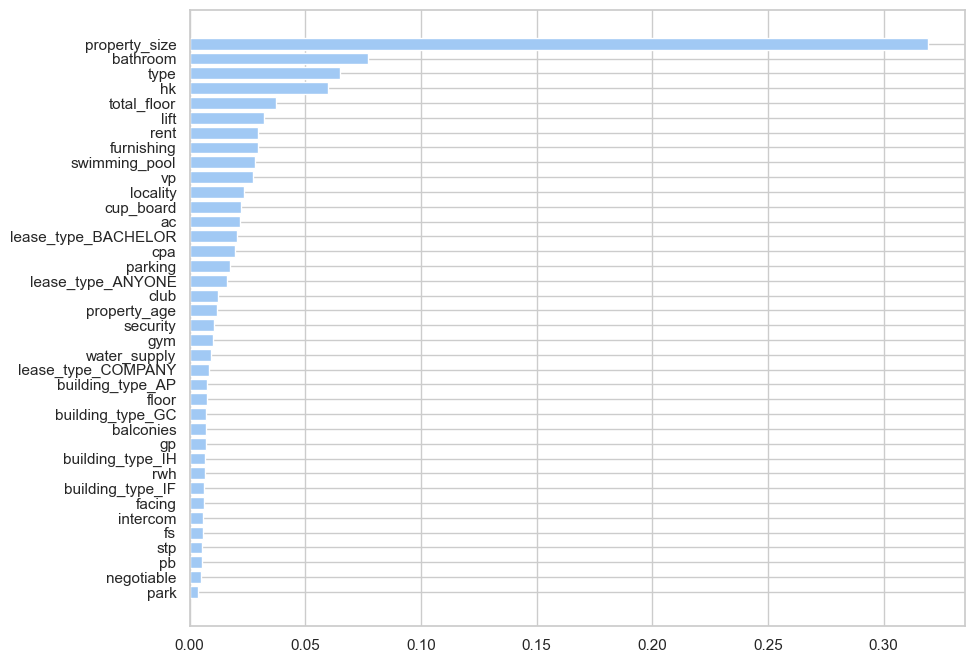

In [107]:
sorted_idx = xgb_regressor.feature_importances_.argsort()
plt.figure(figsize=(10,8))
plt.barh(main_DF.columns[sorted_idx], xgb_regressor.feature_importances_[sorted_idx])
# plt.xlabel("Random Forest Feature Importance")
# plt.title("Feature Importance")
plt.show()

# Suggestions to person looking for Rent:

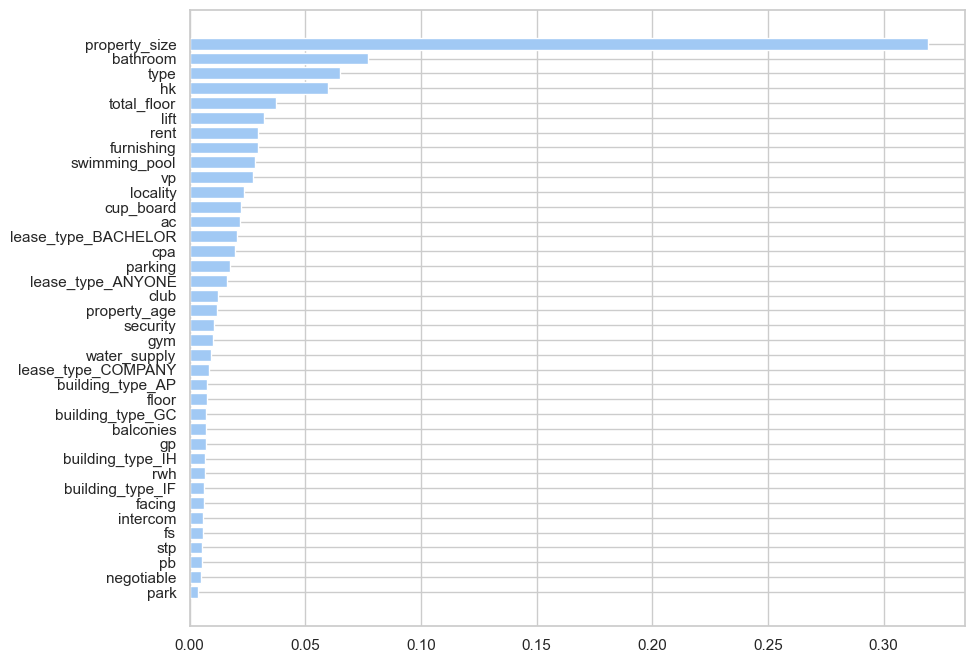

In [108]:
sorted_idx = xgb_regressor.feature_importances_.argsort()
plt.figure(figsize=(10,8))
plt.barh(main_DF.columns[sorted_idx], xgb_regressor.feature_importances_[sorted_idx])
# plt.xlabel("Random Forest Feature Importance")
# plt.title("Feature Importance")
plt.show()